### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import anndata
import scanpy as sc

In [2]:
import seaborn as sns

In [3]:
from torch import nn
from tqdm.notebook import tqdm 
from itertools import chain

In [4]:
from ot_cond.utils import set_seed, createLogHandler, get_G_v2 as get_G, get_dist
from torch import nn
from tqdm import tqdm 
from itertools import chain
from torch.optim import Adam,RMSprop, SGD
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel
from torch.nn import functional as F

In [5]:
%cd ../../../../../examples/bio_new

[Errno 2] No such file or directory: '../../../../../examples/bio_new'
/raid/rachitkd/Conditional-Optimal-Transport/examples/bio_new


In [6]:
import argparse
import os

In [7]:
from torch.utils.data import TensorDataset, DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel

In [8]:
import jax.numpy as jnp
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.geometry import pointcloud

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [9]:
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
SEED = 0
set_seed(SEED)

### Load Data

In [11]:
def read_data(filename='hvg.h5ad'):
    adata = sc.read(filename)
    sc.pp.highly_variable_genes(adata, n_top_genes=1000, subset=True)

    dat = adata.obsm['X_pca']

    # Separate out control cells, 
    ctrl_indices = np.where(adata.obs['dose'].to_numpy()==0)[0]
    print(f'Number of control cells:{len(ctrl_indices)}')
    ctrl_data = dat[ctrl_indices]
    
    # Different y distributions
    y_1 = dat[np.where(adata.obs['drug-dose'].to_numpy()=='givinostat-10')]
    y_2 = dat[np.where(adata.obs['drug-dose'].to_numpy()=='givinostat-100')]
    y_3 = dat[np.where(adata.obs['drug-dose'].to_numpy()=='givinostat-1000')]
    y_4 = dat[np.where(adata.obs['drug-dose'].to_numpy()=='givinostat-10000')]

    return ctrl_data, y_1, y_2, y_3, y_4

def split_data(X, Y1, Y2 , Y3, Y4):
    """
    Split data into training and test datasets
    """
    train_set = []
    test_set = []
    for each in (X, Y1, Y2, Y3, Y4):
        each_train, each_test = train_test_split(each, test_size=0.2, random_state=0)
        train_set.append(each_train)
        test_set.append(each_test)
    
    return tuple(train_set), tuple(test_set)

def get_dataloaders(dataset, batch_size=512):
    """
    Dataset here is not a pytorch dataset, but rather a tuple
    """
    tensor_dl = {}
    
    source_dset = TensorDataset(torch.from_numpy(dataset[0]).float())
    source_dl = DataLoader(source_dset, batch_size=batch_size ,shuffle=True)    
                                
    doses = [10,100,1000,10000]
    for i, each in enumerate(dataset):
        if i == 0:
            continue
        each_dset =TensorDataset(torch.from_numpy(each).float())
        print(torch.from_numpy(each).shape)
        
        dl = DataLoader(each_dset, batch_size=batch_size ,shuffle=True)    
        tensor_dl[doses[i-1]] = dl
    
    # TODO: convert into dict
    return source_dl, tensor_dl

def get_data(filename='hvg.h5ad',setting='insample'):
    """
    Return train and test dataloaders
    """
    X, y_1, y_2, y_3, y_4 = read_data(filename)
    train_set, test_set = split_data(X, y_1, y_2, y_3, y_4)
    X_train_dataloader, Y_train_dataloaders = get_dataloaders(train_set)
    X_test_dataloader, Y_test_dataloaders = get_dataloaders(test_set)

    return X_train_dataloader, Y_train_dataloaders, X_test_dataloader, Y_test_dataloaders


### Define Networks

In [12]:
class Generator(nn.Module):
    def __init__(self, input_dim=50,context_dim=1, out_dim=50, noise_dim=10):
        super(Generator,self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(noise_dim+context_dim+input_dim,128, bias=True),
            nn.LeakyReLU(0.1),
            nn.Linear(128,128),
            #nn.Dropout(0.1),
            nn.LeakyReLU(0.2),
            nn.Linear(128,128),
            #nn.Dropout(0.1),
            nn.LeakyReLU(0.1),
            nn.Linear(128,64),
            #nn.Dropout(0.1),
            nn.LeakyReLU(0.2),
            nn.Linear(64, out_dim),
        )
        
        
        self.input_dim = input_dim
        self.context_dim = context_dim
        self.noise_dim = noise_dim
    
    def forward(self,x):
        out = self.layers(x)
        return out

# Copy Piyushi Di's initialize_weights function 
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

### UTil

In [13]:

def eye_like(G):
    if(len(G.shape) == 3):
        return torch.eye(*G.shape[-2:], out=torch.empty_like(G)).repeat(G.shape[0], 1, 1)
    else: 
        return torch.eye(*G.shape,out=torch.empty_like(G))

In [14]:
def save_model(pi_net, optimizer, epoch):
    torch.save(pi_net.state_dict(),f'{save_as}/model_trained_{epoch}.pth')
    torch.save(optimizer.state_dict(),f'{save_as}/optimizer_trained_{epoch}.pth')
    return

### Hyperparameters

In [15]:

parser = argparse.ArgumentParser(description = '_')
parser.add_argument('--lda', type=float, default=2000) 
parser.add_argument('--ktype', type=str, default="imq")
parser.add_argument('--khp_x', type=float, default=10)
parser.add_argument('--khp_y', type=float, default=10)
parser.add_argument('--n_epochs', type=int, default=500)
parser.add_argument('--lr', type=float, default=2e-3)
parser.add_argument('--noise_dim', type=int, default=10)
parser.add_argument('--n_noise', type=int, default=20)
parser.add_argument('--opti_type', type=str, default="adam")
parser.add_argument('--log_fname', type=str, default="logs_final_run")
parser.add_argument('--save_as', required=False, type=str, default="")
args = parser.parse_args(args=[])
print(args)

Namespace(lda=2000, ktype='imq', khp_x=10, khp_y=10, n_epochs=500, lr=0.002, noise_dim=10, n_noise=20, opti_type='adam', log_fname='logs_final_run', save_as='')


In [16]:
# Hyperparameters
lambda_reg = args.lda
ktype = args.ktype
khp_x = args.khp_x
khp_y = args.khp_y
num_epochs = args.n_epochs
lr = args.lr
opti_type = args.opti_type
save_as = f"{lambda_reg}_{ktype}_{khp_x}_{khp_y}_{opti_type}_{args.noise_dim}" + args.save_as

n_noise = args.n_noise
noise_dim = args.noise_dim


### Instantiate

In [17]:
X_train_dataloader, Y_train_dataloaders, X_test_dataloader, Y_test_dataloaders =  get_data(filename='./datasets/hvg.h5ad')


Number of control cells:17565
torch.Size([812, 50])
torch.Size([790, 50])
torch.Size([654, 50])
torch.Size([575, 50])
torch.Size([204, 50])
torch.Size([198, 50])
torch.Size([164, 50])
torch.Size([144, 50])


In [18]:
pi_net = Generator(noise_dim=noise_dim)
pi_net.apply(initialize_weights)
pi_net = pi_net.to(device)
pi_net.train()

Generator(
  (layers): Sequential(
    (0): Linear(in_features=61, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=64, out_features=50, bias=True)
  )
)

In [19]:
optimizer = Adam(pi_net.parameters(), lr=lr, betas=(0.9,0.99))
scheduler = StepLR(optimizer, step_size=200, gamma=0.8)
scheduler = None

### Train

In [20]:

def train(pi_net, optimizer, X_train_dataloader, Y_train_dataloaders, scheduler=None):
    objs = []
    tcosts = []
    reg_costs = []
    best_obj = None # NOTE: ADDED
    v_gen = torch.Tensor(n_noise*[1.0/n_noise]).to(dtype).to(device)
    Z_qs = torch.Tensor([10,100,1000,10000]).to(dtype).to(device) 
    # IMP: The order of contexts here must be the same as order in Y_dataloaders
    # TODO: if out of sample, quit on the required context
    for epoch in tqdm(range(num_epochs)):
        obj_epoch = 0.
        tcost_epoch = 0.
        reg_epoch = 0.
        pi_net.train()
        
        
        for idx, X_ in enumerate(X_train_dataloader):
            X = X_[0].to(device) # pytorch dataloader returns list, but we want only the first element
            tcost = 0.
            reg_y = 0.
            obj = 0.
            # now loop over all Z:
            n_x = len(X)
            #for i, ctx in enumerate(Z_qs):
            for ctx, dl in Y_train_dataloaders.items():
                
                ctx = torch.Tensor([ctx]).to(device)
                
                #Y_Z_ = next(iter(Y_train_dataloaders[10]))
                
                Y_Z_ = next(iter(dl))
                Y_Z = Y_Z_[0].to(device)

                #print(ctx.repeat(n_x,1).shape)
                ZX = torch.cat([X, ctx.repeat(n_x,1)], dim=1)
                n_s = torch.randn(n_noise*n_x, noise_dim).to(device)
                ZXn = torch.cat([ZX.repeat_interleave(n_noise,0), n_s],dim=1)

                #print(ZX.shape)
                #print(ZXn.shape)
                k = Y_Z.shape[0]
                v_gen = torch.Tensor(ZXn.shape[0]*[1.0/ZXn.shape[0]]).to(dtype).to(device)
                
                v_ygz = -1*torch.Tensor(k*[1.0/k]).to(dtype).to(device)
                v = torch.cat([v_gen, v_ygz], dim=0).to(dtype).to(device)
                
                Y_gen = pi_net(ZXn)
                
                C = get_dist(X, Y_gen)
                
                reqd_indices = torch.eye(C.shape[0]).to(device).repeat_interleave(n_noise,dim=1)
                C = C*reqd_indices / 100
                # C = F.normalize(C, p=float('inf'), dim=[0,1])
                
                cat_Y = torch.vstack([Y_gen, Y_Z])
                
                #v = (1/cat_Y.shape[0])*torch.ones(cat_Y.shape[0]).to(dtype).to(device)
                G_cat = get_G(khp=khp_y, x=cat_Y, y=cat_Y, ktype=ktype)
                
                #print(G_cat.shape, v.shape)
                reg_y = reg_y + torch.mv(G_cat, v).dot(v)
                tcost = tcost + torch.sum(C)/(len(Z_qs)*(ZXn.shape[0]))
            
            obj = (tcost + lambda_reg*reg_y)/4
            
            # optimizer updates after looping for all Z
            optimizer.zero_grad()
            obj.backward()
            optimizer.step()
            
            obj_epoch += obj
            tcost_epoch += tcost
            reg_epoch += reg_y
        #if epoch == 0:
        #    print(f'Cond No.{torch.linalg.cond(G_cat)}')
        #print(f'Tcost: {tcost_epoch}, reg_cost: {reg_epoch}, Objective: {obj_epoch}')
        
        objs.append(obj_epoch)
        tcosts.append(tcost_epoch)
        reg_costs.append(reg_epoch)
        print(obj_epoch, tcost_epoch, reg_epoch)
        if scheduler:
            scheduler.step()

        if epoch % 50 == 0 and (best_obj is None or best_obj > objs[-1].item()):
            #cond_no = torch.linalg.cond(G_cat)
            #print(cond_no)
            best_obj = objs[-1].item()
            #save_model(pi_net, optimizer, epoch)
            #logger.info(f'{obj_epoch}, {tcost_epoch}, {reg_epoch}, {epoch}')


    return pi_net, optimizer

In [21]:
train(pi_net, optimizer, X_train_dataloader,Y_train_dataloaders, scheduler)

  0%|          | 1/500 [00:04<40:52,  4.92s/it]

tensor(239430.7812, device='cuda:0', grad_fn=<AddBackward0>) tensor(938468.8125, device='cuda:0', grad_fn=<AddBackward0>) tensor(9.6272, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 2/500 [00:09<40:59,  4.94s/it]

tensor(4793.3794, device='cuda:0', grad_fn=<AddBackward0>) tensor(6513.8862, device='cuda:0', grad_fn=<AddBackward0>) tensor(6.3298, device='cuda:0', grad_fn=<AddBackward0>)


  1%|          | 3/500 [00:15<42:03,  5.08s/it]

tensor(2362.6216, device='cuda:0', grad_fn=<AddBackward0>) tensor(718.1505, device='cuda:0', grad_fn=<AddBackward0>) tensor(4.3662, device='cuda:0', grad_fn=<AddBackward0>)


  1%|          | 4/500 [00:19<40:50,  4.94s/it]

tensor(2525.2209, device='cuda:0', grad_fn=<AddBackward0>) tensor(1150.1836, device='cuda:0', grad_fn=<AddBackward0>) tensor(4.4753, device='cuda:0', grad_fn=<AddBackward0>)


  1%|          | 5/500 [00:24<40:17,  4.88s/it]

tensor(2559.9856, device='cuda:0', grad_fn=<AddBackward0>) tensor(1355.3722, device='cuda:0', grad_fn=<AddBackward0>) tensor(4.4423, device='cuda:0', grad_fn=<AddBackward0>)


  1%|          | 6/500 [00:28<38:36,  4.69s/it]

tensor(2458.1377, device='cuda:0', grad_fn=<AddBackward0>) tensor(1253.5122, device='cuda:0', grad_fn=<AddBackward0>) tensor(4.2895, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏         | 7/500 [00:33<37:40,  4.58s/it]

tensor(2318.2310, device='cuda:0', grad_fn=<AddBackward0>) tensor(969.6058, device='cuda:0', grad_fn=<AddBackward0>) tensor(4.1517, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏         | 8/500 [00:37<37:21,  4.56s/it]

tensor(2399.1462, device='cuda:0', grad_fn=<AddBackward0>) tensor(1209.1960, device='cuda:0', grad_fn=<AddBackward0>) tensor(4.1937, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏         | 9/500 [00:42<37:35,  4.59s/it]

tensor(2206.7356, device='cuda:0', grad_fn=<AddBackward0>) tensor(842.6782, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.9921, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏         | 10/500 [00:47<37:32,  4.60s/it]

tensor(2122.7917, device='cuda:0', grad_fn=<AddBackward0>) tensor(725.1041, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.8830, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏         | 11/500 [00:51<36:58,  4.54s/it]

tensor(2153.8284, device='cuda:0', grad_fn=<AddBackward0>) tensor(823.5425, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.8959, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏         | 12/500 [00:56<37:33,  4.62s/it]

tensor(2223.2661, device='cuda:0', grad_fn=<AddBackward0>) tensor(964.5029, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.9643, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▎         | 13/500 [01:00<36:39,  4.52s/it]

tensor(2411.9785, device='cuda:0', grad_fn=<AddBackward0>) tensor(1405.2640, device='cuda:0', grad_fn=<AddBackward0>) tensor(4.1213, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▎         | 14/500 [01:04<36:20,  4.49s/it]

tensor(2311.9111, device='cuda:0', grad_fn=<AddBackward0>) tensor(1242.0704, device='cuda:0', grad_fn=<AddBackward0>) tensor(4.0028, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▎         | 15/500 [01:09<36:01,  4.46s/it]

tensor(2310.6375, device='cuda:0', grad_fn=<AddBackward0>) tensor(1415.2877, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.9136, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▎         | 16/500 [01:13<35:50,  4.44s/it]

tensor(2285.0325, device='cuda:0', grad_fn=<AddBackward0>) tensor(1271.1644, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.9345, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▎         | 17/500 [01:18<35:39,  4.43s/it]

tensor(2305.6218, device='cuda:0', grad_fn=<AddBackward0>) tensor(1428.0172, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.8972, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▎         | 18/500 [01:22<35:23,  4.41s/it]

tensor(2108.2107, device='cuda:0', grad_fn=<AddBackward0>) tensor(931.8293, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.7505, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▍         | 19/500 [01:27<36:23,  4.54s/it]

tensor(2153.6245, device='cuda:0', grad_fn=<AddBackward0>) tensor(979.8967, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.8173, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▍         | 20/500 [01:31<35:57,  4.49s/it]

tensor(2028.4481, device='cuda:0', grad_fn=<AddBackward0>) tensor(704.6116, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.7046, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▍         | 21/500 [01:36<35:24,  4.44s/it]

tensor(2097.6699, device='cuda:0', grad_fn=<AddBackward0>) tensor(905.2942, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.7427, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▍         | 22/500 [01:40<35:05,  4.41s/it]

tensor(2092.6162, device='cuda:0', grad_fn=<AddBackward0>) tensor(949.3865, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.7105, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▍         | 23/500 [01:45<35:46,  4.50s/it]

tensor(2021.0947, device='cuda:0', grad_fn=<AddBackward0>) tensor(878.9849, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.6027, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▍         | 24/500 [01:49<35:32,  4.48s/it]

tensor(1855.2510, device='cuda:0', grad_fn=<AddBackward0>) tensor(629.2128, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.3959, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▌         | 25/500 [01:53<35:20,  4.46s/it]

tensor(1852.2365, device='cuda:0', grad_fn=<AddBackward0>) tensor(631.6932, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.3886, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▌         | 26/500 [01:58<35:11,  4.46s/it]

tensor(1981.4847, device='cuda:0', grad_fn=<AddBackward0>) tensor(738.5597, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.5937, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▌         | 27/500 [02:02<35:08,  4.46s/it]

tensor(1839.8665, device='cuda:0', grad_fn=<AddBackward0>) tensor(529.7581, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.4149, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▌         | 28/500 [02:07<34:49,  4.43s/it]

tensor(1848.3921, device='cuda:0', grad_fn=<AddBackward0>) tensor(547.3516, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.4231, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▌         | 29/500 [02:11<35:17,  4.50s/it]

tensor(1760.6292, device='cuda:0', grad_fn=<AddBackward0>) tensor(407.0805, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.3177, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▌         | 30/500 [02:16<34:58,  4.47s/it]

tensor(1787.6954, device='cuda:0', grad_fn=<AddBackward0>) tensor(493.8439, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.3285, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▌         | 31/500 [02:20<34:42,  4.44s/it]

tensor(1681.0055, device='cuda:0', grad_fn=<AddBackward0>) tensor(391.8720, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.1661, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▋         | 32/500 [02:25<34:30,  4.42s/it]

tensor(1579.6477, device='cuda:0', grad_fn=<AddBackward0>) tensor(350.5669, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.9840, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▋         | 33/500 [02:29<34:44,  4.46s/it]

tensor(1496.6677, device='cuda:0', grad_fn=<AddBackward0>) tensor(294.4225, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.8461, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▋         | 34/500 [02:34<34:30,  4.44s/it]

tensor(1488.1025, device='cuda:0', grad_fn=<AddBackward0>) tensor(240.0386, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.8562, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▋         | 35/500 [02:38<34:35,  4.46s/it]

tensor(1520.2557, device='cuda:0', grad_fn=<AddBackward0>) tensor(317.0564, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.8820, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▋         | 36/500 [02:42<34:26,  4.45s/it]

tensor(1283.9156, device='cuda:0', grad_fn=<AddBackward0>) tensor(192.4720, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.4716, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▋         | 37/500 [02:47<34:14,  4.44s/it]

tensor(1576.5806, device='cuda:0', grad_fn=<AddBackward0>) tensor(337.0938, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.9846, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▊         | 38/500 [02:51<34:01,  4.42s/it]

tensor(1287.4867, device='cuda:0', grad_fn=<AddBackward0>) tensor(202.4712, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.4737, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▊         | 39/500 [02:56<33:59,  4.42s/it]

tensor(1358.8207, device='cuda:0', grad_fn=<AddBackward0>) tensor(240.4118, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.5974, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▊         | 40/500 [03:00<34:32,  4.51s/it]

tensor(1470.7893, device='cuda:0', grad_fn=<AddBackward0>) tensor(323.6010, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7798, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▊         | 41/500 [03:05<34:26,  4.50s/it]

tensor(1398.2590, device='cuda:0', grad_fn=<AddBackward0>) tensor(240.6909, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.6762, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▊         | 42/500 [03:09<34:21,  4.50s/it]

tensor(1337.6023, device='cuda:0', grad_fn=<AddBackward0>) tensor(227.1164, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.5616, device='cuda:0', grad_fn=<AddBackward0>)


  9%|▊         | 43/500 [03:14<34:51,  4.58s/it]

tensor(1226.8914, device='cuda:0', grad_fn=<AddBackward0>) tensor(182.0595, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.3628, device='cuda:0', grad_fn=<AddBackward0>)


  9%|▉         | 44/500 [03:19<34:23,  4.52s/it]

tensor(953.0991, device='cuda:0', grad_fn=<AddBackward0>) tensor(137.1383, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8376, device='cuda:0', grad_fn=<AddBackward0>)


  9%|▉         | 45/500 [03:23<34:03,  4.49s/it]

tensor(1308.8113, device='cuda:0', grad_fn=<AddBackward0>) tensor(214.6823, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.5103, device='cuda:0', grad_fn=<AddBackward0>)


  9%|▉         | 46/500 [03:27<33:44,  4.46s/it]

tensor(1089.3644, device='cuda:0', grad_fn=<AddBackward0>) tensor(170.5704, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0934, device='cuda:0', grad_fn=<AddBackward0>)


  9%|▉         | 47/500 [03:32<33:35,  4.45s/it]

tensor(997.6013, device='cuda:0', grad_fn=<AddBackward0>) tensor(142.4207, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.9240, device='cuda:0', grad_fn=<AddBackward0>)


 10%|▉         | 48/500 [03:36<33:26,  4.44s/it]

tensor(785.2836, device='cuda:0', grad_fn=<AddBackward0>) tensor(106.7001, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5172, device='cuda:0', grad_fn=<AddBackward0>)


 10%|▉         | 49/500 [03:41<33:17,  4.43s/it]

tensor(764.6582, device='cuda:0', grad_fn=<AddBackward0>) tensor(105.8440, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4764, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█         | 50/500 [03:45<33:53,  4.52s/it]

tensor(783.9285, device='cuda:0', grad_fn=<AddBackward0>) tensor(109.0970, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5133, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█         | 51/500 [03:50<33:35,  4.49s/it]

tensor(882.8976, device='cuda:0', grad_fn=<AddBackward0>) tensor(121.4479, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7051, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█         | 52/500 [03:54<33:19,  4.46s/it]

tensor(488.2050, device='cuda:0', grad_fn=<AddBackward0>) tensor(85.9092, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9335, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█         | 53/500 [03:59<33:53,  4.55s/it]

tensor(794.4637, device='cuda:0', grad_fn=<AddBackward0>) tensor(100.4179, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5387, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█         | 54/500 [04:03<33:33,  4.51s/it]

tensor(823.1541, device='cuda:0', grad_fn=<AddBackward0>) tensor(103.7678, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5944, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█         | 55/500 [04:08<33:35,  4.53s/it]

tensor(719.7629, device='cuda:0', grad_fn=<AddBackward0>) tensor(100.1854, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3894, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█         | 56/500 [04:12<33:25,  4.52s/it]

tensor(874.7475, device='cuda:0', grad_fn=<AddBackward0>) tensor(102.7810, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6981, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▏        | 57/500 [04:17<33:23,  4.52s/it]

tensor(907.2288, device='cuda:0', grad_fn=<AddBackward0>) tensor(114.2864, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7573, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▏        | 58/500 [04:21<33:04,  4.49s/it]

tensor(572.4236, device='cuda:0', grad_fn=<AddBackward0>) tensor(93.5771, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0981, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▏        | 59/500 [04:26<32:48,  4.46s/it]

tensor(385.6374, device='cuda:0', grad_fn=<AddBackward0>) tensor(76.9202, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7328, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▏        | 60/500 [04:30<32:56,  4.49s/it]

tensor(326.0729, device='cuda:0', grad_fn=<AddBackward0>) tensor(74.1190, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6151, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▏        | 61/500 [04:35<32:24,  4.43s/it]

tensor(584.3383, device='cuda:0', grad_fn=<AddBackward0>) tensor(102.1839, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1176, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▏        | 62/500 [04:39<32:05,  4.40s/it]

tensor(882.1771, device='cuda:0', grad_fn=<AddBackward0>) tensor(118.5943, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7051, device='cuda:0', grad_fn=<AddBackward0>)


 13%|█▎        | 63/500 [04:44<33:08,  4.55s/it]

tensor(625.2384, device='cuda:0', grad_fn=<AddBackward0>) tensor(89.0470, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2060, device='cuda:0', grad_fn=<AddBackward0>)


 13%|█▎        | 64/500 [04:48<32:40,  4.50s/it]

tensor(685.6702, device='cuda:0', grad_fn=<AddBackward0>) tensor(89.6842, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3265, device='cuda:0', grad_fn=<AddBackward0>)


 13%|█▎        | 65/500 [04:52<32:03,  4.42s/it]

tensor(545.8235, device='cuda:0', grad_fn=<AddBackward0>) tensor(82.1489, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0506, device='cuda:0', grad_fn=<AddBackward0>)


 13%|█▎        | 66/500 [04:57<31:43,  4.39s/it]

tensor(537.4363, device='cuda:0', grad_fn=<AddBackward0>) tensor(81.9059, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0339, device='cuda:0', grad_fn=<AddBackward0>)


 13%|█▎        | 67/500 [05:01<31:37,  4.38s/it]

tensor(455.3061, device='cuda:0', grad_fn=<AddBackward0>) tensor(77.9596, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8716, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▎        | 68/500 [05:05<31:25,  4.36s/it]

tensor(347.9679, device='cuda:0', grad_fn=<AddBackward0>) tensor(73.9321, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6590, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▍        | 69/500 [05:10<31:26,  4.38s/it]

tensor(267.8352, device='cuda:0', grad_fn=<AddBackward0>) tensor(70.4083, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5005, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▍        | 70/500 [05:15<32:21,  4.52s/it]

tensor(235.4651, device='cuda:0', grad_fn=<AddBackward0>) tensor(67.9226, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4370, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▍        | 71/500 [05:19<32:17,  4.52s/it]

tensor(197.6382, device='cuda:0', grad_fn=<AddBackward0>) tensor(66.3895, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3621, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▍        | 72/500 [05:24<32:07,  4.50s/it]

tensor(224.4141, device='cuda:0', grad_fn=<AddBackward0>) tensor(66.3364, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█▍        | 73/500 [05:28<31:58,  4.49s/it]

tensor(223.6328, device='cuda:0', grad_fn=<AddBackward0>) tensor(66.0346, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4142, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█▍        | 74/500 [05:33<32:19,  4.55s/it]

tensor(207.1735, device='cuda:0', grad_fn=<AddBackward0>) tensor(65.6434, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3815, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█▌        | 75/500 [05:37<32:02,  4.52s/it]

tensor(167.6024, device='cuda:0', grad_fn=<AddBackward0>) tensor(64.0780, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3032, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█▌        | 76/500 [05:42<32:48,  4.64s/it]

tensor(158.5270, device='cuda:0', grad_fn=<AddBackward0>) tensor(63.6377, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2852, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█▌        | 77/500 [05:47<32:17,  4.58s/it]

tensor(438.6849, device='cuda:0', grad_fn=<AddBackward0>) tensor(95.9072, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8294, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█▌        | 78/500 [05:51<31:59,  4.55s/it]

tensor(1036.8718, device='cuda:0', grad_fn=<AddBackward0>) tensor(142.9649, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0023, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█▌        | 79/500 [05:55<31:41,  4.52s/it]

tensor(663.8710, device='cuda:0', grad_fn=<AddBackward0>) tensor(91.2639, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2821, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█▌        | 80/500 [06:00<32:20,  4.62s/it]

tensor(440.0142, device='cuda:0', grad_fn=<AddBackward0>) tensor(73.9051, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8431, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█▌        | 81/500 [06:05<31:45,  4.55s/it]

tensor(428.2290, device='cuda:0', grad_fn=<AddBackward0>) tensor(71.0053, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8210, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█▋        | 82/500 [06:09<31:23,  4.51s/it]

tensor(281.1939, device='cuda:0', grad_fn=<AddBackward0>) tensor(68.7827, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5280, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▋        | 83/500 [06:14<31:11,  4.49s/it]

tensor(162.1522, device='cuda:0', grad_fn=<AddBackward0>) tensor(63.3473, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2926, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▋        | 84/500 [06:19<32:00,  4.62s/it]

tensor(156.7063, device='cuda:0', grad_fn=<AddBackward0>) tensor(63.1947, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2818, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▋        | 85/500 [06:23<31:33,  4.56s/it]

tensor(147.6539, device='cuda:0', grad_fn=<AddBackward0>) tensor(62.8442, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2639, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▋        | 86/500 [06:27<31:14,  4.53s/it]

tensor(142.2971, device='cuda:0', grad_fn=<AddBackward0>) tensor(61.9345, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2536, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▋        | 87/500 [06:32<31:04,  4.51s/it]

tensor(135.5564, device='cuda:0', grad_fn=<AddBackward0>) tensor(61.6284, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2403, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▊        | 88/500 [06:36<30:45,  4.48s/it]

tensor(161.5365, device='cuda:0', grad_fn=<AddBackward0>) tensor(62.3191, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2919, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▊        | 89/500 [06:41<30:29,  4.45s/it]

tensor(135.0901, device='cuda:0', grad_fn=<AddBackward0>) tensor(61.1505, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2396, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▊        | 90/500 [06:45<30:06,  4.41s/it]

tensor(128.8649, device='cuda:0', grad_fn=<AddBackward0>) tensor(60.7610, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2273, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▊        | 91/500 [06:50<30:34,  4.48s/it]

tensor(148.8836, device='cuda:0', grad_fn=<AddBackward0>) tensor(61.0392, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2672, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▊        | 92/500 [06:54<30:15,  4.45s/it]

tensor(393.3160, device='cuda:0', grad_fn=<AddBackward0>) tensor(86.0576, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7436, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▊        | 93/500 [06:58<29:58,  4.42s/it]

tensor(1077.8966, device='cuda:0', grad_fn=<AddBackward0>) tensor(146.2141, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0827, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▉        | 94/500 [07:03<30:20,  4.48s/it]

tensor(709.7995, device='cuda:0', grad_fn=<AddBackward0>) tensor(91.5519, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3738, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▉        | 95/500 [07:07<30:10,  4.47s/it]

tensor(395.9779, device='cuda:0', grad_fn=<AddBackward0>) tensor(71.7585, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7561, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▉        | 96/500 [07:12<30:02,  4.46s/it]

tensor(229.5208, device='cuda:0', grad_fn=<AddBackward0>) tensor(64.6548, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4267, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▉        | 97/500 [07:16<29:55,  4.46s/it]

tensor(157.7610, device='cuda:0', grad_fn=<AddBackward0>) tensor(62.4622, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2843, device='cuda:0', grad_fn=<AddBackward0>)


 20%|█▉        | 98/500 [07:21<29:36,  4.42s/it]

tensor(120.9997, device='cuda:0', grad_fn=<AddBackward0>) tensor(60.8879, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2116, device='cuda:0', grad_fn=<AddBackward0>)


 20%|█▉        | 99/500 [07:25<29:32,  4.42s/it]

tensor(128.5341, device='cuda:0', grad_fn=<AddBackward0>) tensor(60.7440, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2267, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██        | 100/500 [07:29<29:13,  4.38s/it]

tensor(126.9984, device='cuda:0', grad_fn=<AddBackward0>) tensor(60.7658, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2236, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██        | 101/500 [07:34<29:34,  4.45s/it]

tensor(127.5393, device='cuda:0', grad_fn=<AddBackward0>) tensor(60.0594, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2250, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██        | 102/500 [07:38<29:27,  4.44s/it]

tensor(121.7710, device='cuda:0', grad_fn=<AddBackward0>) tensor(60.0627, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2135, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██        | 103/500 [07:43<29:26,  4.45s/it]

tensor(122.6331, device='cuda:0', grad_fn=<AddBackward0>) tensor(59.9939, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2153, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██        | 104/500 [07:48<30:04,  4.56s/it]

tensor(132.3315, device='cuda:0', grad_fn=<AddBackward0>) tensor(60.0002, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2347, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██        | 105/500 [07:52<30:01,  4.56s/it]

tensor(115.7891, device='cuda:0', grad_fn=<AddBackward0>) tensor(59.8373, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2017, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██        | 106/500 [07:57<29:40,  4.52s/it]

tensor(130.2262, device='cuda:0', grad_fn=<AddBackward0>) tensor(60.0068, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2304, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▏       | 107/500 [08:01<29:32,  4.51s/it]

tensor(127.6286, device='cuda:0', grad_fn=<AddBackward0>) tensor(59.3043, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2256, device='cuda:0', grad_fn=<AddBackward0>)


 22%|██▏       | 108/500 [08:06<29:25,  4.50s/it]

tensor(740.4821, device='cuda:0', grad_fn=<AddBackward0>) tensor(105.1751, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4284, device='cuda:0', grad_fn=<AddBackward0>)


 22%|██▏       | 109/500 [08:10<29:01,  4.45s/it]

tensor(391.4965, device='cuda:0', grad_fn=<AddBackward0>) tensor(69.9110, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7480, device='cuda:0', grad_fn=<AddBackward0>)


 22%|██▏       | 110/500 [08:14<28:35,  4.40s/it]

tensor(183.5029, device='cuda:0', grad_fn=<AddBackward0>) tensor(62.7757, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3356, device='cuda:0', grad_fn=<AddBackward0>)


 22%|██▏       | 111/500 [08:19<28:59,  4.47s/it]

tensor(119.2252, device='cuda:0', grad_fn=<AddBackward0>) tensor(60.2937, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2083, device='cuda:0', grad_fn=<AddBackward0>)


 22%|██▏       | 112/500 [08:23<28:38,  4.43s/it]

tensor(107.9721, device='cuda:0', grad_fn=<AddBackward0>) tensor(59.3497, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1863, device='cuda:0', grad_fn=<AddBackward0>)


 23%|██▎       | 113/500 [08:28<28:25,  4.41s/it]

tensor(103.0434, device='cuda:0', grad_fn=<AddBackward0>) tensor(58.7499, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1767, device='cuda:0', grad_fn=<AddBackward0>)


 23%|██▎       | 114/500 [08:32<28:09,  4.38s/it]

tensor(102.5202, device='cuda:0', grad_fn=<AddBackward0>) tensor(58.6876, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1757, device='cuda:0', grad_fn=<AddBackward0>)


 23%|██▎       | 115/500 [08:37<28:42,  4.47s/it]

tensor(116.5686, device='cuda:0', grad_fn=<AddBackward0>) tensor(58.6714, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2038, device='cuda:0', grad_fn=<AddBackward0>)


 23%|██▎       | 116/500 [08:41<28:30,  4.45s/it]

tensor(107.4860, device='cuda:0', grad_fn=<AddBackward0>) tensor(58.4414, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1858, device='cuda:0', grad_fn=<AddBackward0>)


 23%|██▎       | 117/500 [08:45<28:31,  4.47s/it]

tensor(99.4444, device='cuda:0', grad_fn=<AddBackward0>) tensor(57.9346, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1699, device='cuda:0', grad_fn=<AddBackward0>)


 24%|██▎       | 118/500 [08:50<28:24,  4.46s/it]

tensor(105.6639, device='cuda:0', grad_fn=<AddBackward0>) tensor(57.8838, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1824, device='cuda:0', grad_fn=<AddBackward0>)


 24%|██▍       | 119/500 [08:54<28:17,  4.45s/it]

tensor(102.9521, device='cuda:0', grad_fn=<AddBackward0>) tensor(57.9071, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1770, device='cuda:0', grad_fn=<AddBackward0>)


 24%|██▍       | 120/500 [08:59<28:18,  4.47s/it]

tensor(101.5348, device='cuda:0', grad_fn=<AddBackward0>) tensor(57.5357, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1743, device='cuda:0', grad_fn=<AddBackward0>)


 24%|██▍       | 121/500 [09:04<28:43,  4.55s/it]

tensor(665.8157, device='cuda:0', grad_fn=<AddBackward0>) tensor(99.4209, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2819, device='cuda:0', grad_fn=<AddBackward0>)


 24%|██▍       | 122/500 [09:08<28:25,  4.51s/it]

tensor(723.9590, device='cuda:0', grad_fn=<AddBackward0>) tensor(97.9726, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3989, device='cuda:0', grad_fn=<AddBackward0>)


 25%|██▍       | 123/500 [09:12<28:08,  4.48s/it]

tensor(283.9280, device='cuda:0', grad_fn=<AddBackward0>) tensor(63.7000, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5360, device='cuda:0', grad_fn=<AddBackward0>)


 25%|██▍       | 124/500 [09:17<27:57,  4.46s/it]

tensor(135.7317, device='cuda:0', grad_fn=<AddBackward0>) tensor(59.1092, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2419, device='cuda:0', grad_fn=<AddBackward0>)


 25%|██▌       | 125/500 [09:22<28:26,  4.55s/it]

tensor(109.6503, device='cuda:0', grad_fn=<AddBackward0>) tensor(58.2144, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1902, device='cuda:0', grad_fn=<AddBackward0>)


 25%|██▌       | 126/500 [09:26<27:51,  4.47s/it]

tensor(100.8426, device='cuda:0', grad_fn=<AddBackward0>) tensor(57.6651, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1729, device='cuda:0', grad_fn=<AddBackward0>)


 25%|██▌       | 127/500 [09:30<27:43,  4.46s/it]

tensor(99.5880, device='cuda:0', grad_fn=<AddBackward0>) tensor(57.5595, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1704, device='cuda:0', grad_fn=<AddBackward0>)


 26%|██▌       | 128/500 [09:35<27:33,  4.44s/it]

tensor(96.6551, device='cuda:0', grad_fn=<AddBackward0>) tensor(57.1611, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1647, device='cuda:0', grad_fn=<AddBackward0>)


 26%|██▌       | 129/500 [09:39<27:20,  4.42s/it]

tensor(96.3322, device='cuda:0', grad_fn=<AddBackward0>) tensor(57.1351, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1641, device='cuda:0', grad_fn=<AddBackward0>)


 26%|██▌       | 130/500 [09:44<27:19,  4.43s/it]

tensor(106.4607, device='cuda:0', grad_fn=<AddBackward0>) tensor(57.4436, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1842, device='cuda:0', grad_fn=<AddBackward0>)


 26%|██▌       | 131/500 [09:48<27:24,  4.46s/it]

tensor(97.4028, device='cuda:0', grad_fn=<AddBackward0>) tensor(56.9966, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1663, device='cuda:0', grad_fn=<AddBackward0>)


 26%|██▋       | 132/500 [09:53<27:58,  4.56s/it]

tensor(94.0822, device='cuda:0', grad_fn=<AddBackward0>) tensor(56.8145, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1598, device='cuda:0', grad_fn=<AddBackward0>)


 27%|██▋       | 133/500 [09:57<27:25,  4.48s/it]

tensor(94.2796, device='cuda:0', grad_fn=<AddBackward0>) tensor(56.5141, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1603, device='cuda:0', grad_fn=<AddBackward0>)


 27%|██▋       | 134/500 [10:01<26:59,  4.42s/it]

tensor(104.2647, device='cuda:0', grad_fn=<AddBackward0>) tensor(56.6748, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1802, device='cuda:0', grad_fn=<AddBackward0>)


 27%|██▋       | 135/500 [10:06<27:39,  4.55s/it]

tensor(115.4405, device='cuda:0', grad_fn=<AddBackward0>) tensor(57.6227, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2021, device='cuda:0', grad_fn=<AddBackward0>)


 27%|██▋       | 136/500 [10:11<27:19,  4.50s/it]

tensor(100.8794, device='cuda:0', grad_fn=<AddBackward0>) tensor(56.7309, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1734, device='cuda:0', grad_fn=<AddBackward0>)


 27%|██▋       | 137/500 [10:15<27:04,  4.48s/it]

tensor(95.5149, device='cuda:0', grad_fn=<AddBackward0>) tensor(56.4265, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1628, device='cuda:0', grad_fn=<AddBackward0>)


 28%|██▊       | 138/500 [10:20<26:51,  4.45s/it]

tensor(106.6406, device='cuda:0', grad_fn=<AddBackward0>) tensor(56.6044, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1850, device='cuda:0', grad_fn=<AddBackward0>)


 28%|██▊       | 139/500 [10:24<26:40,  4.43s/it]

tensor(94.6155, device='cuda:0', grad_fn=<AddBackward0>) tensor(56.7547, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1609, device='cuda:0', grad_fn=<AddBackward0>)


 28%|██▊       | 140/500 [10:28<26:36,  4.43s/it]

tensor(88.6154, device='cuda:0', grad_fn=<AddBackward0>) tensor(55.7902, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1493, device='cuda:0', grad_fn=<AddBackward0>)


 28%|██▊       | 141/500 [10:33<26:26,  4.42s/it]

tensor(93.5827, device='cuda:0', grad_fn=<AddBackward0>) tensor(56.0215, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1592, device='cuda:0', grad_fn=<AddBackward0>)


 28%|██▊       | 142/500 [10:37<26:54,  4.51s/it]

tensor(87.1899, device='cuda:0', grad_fn=<AddBackward0>) tensor(56.0443, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)


 29%|██▊       | 143/500 [10:42<26:52,  4.52s/it]

tensor(91.1741, device='cuda:0', grad_fn=<AddBackward0>) tensor(56.0282, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1543, device='cuda:0', grad_fn=<AddBackward0>)


 29%|██▉       | 144/500 [10:47<26:50,  4.52s/it]

tensor(823.4304, device='cuda:0', grad_fn=<AddBackward0>) tensor(148.2023, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5728, device='cuda:0', grad_fn=<AddBackward0>)


 29%|██▉       | 145/500 [10:51<26:55,  4.55s/it]

tensor(749.1609, device='cuda:0', grad_fn=<AddBackward0>) tensor(94.9315, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4509, device='cuda:0', grad_fn=<AddBackward0>)


 29%|██▉       | 146/500 [10:56<26:41,  4.52s/it]

tensor(272.4136, device='cuda:0', grad_fn=<AddBackward0>) tensor(61.5855, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5140, device='cuda:0', grad_fn=<AddBackward0>)


 29%|██▉       | 147/500 [11:00<26:25,  4.49s/it]

tensor(118.0520, device='cuda:0', grad_fn=<AddBackward0>) tensor(57.8619, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2072, device='cuda:0', grad_fn=<AddBackward0>)


 30%|██▉       | 148/500 [11:04<26:20,  4.49s/it]

tensor(92.6666, device='cuda:0', grad_fn=<AddBackward0>) tensor(56.7844, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)


 30%|██▉       | 149/500 [11:09<26:07,  4.47s/it]

tensor(87.5338, device='cuda:0', grad_fn=<AddBackward0>) tensor(56.7006, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1467, device='cuda:0', grad_fn=<AddBackward0>)


 30%|███       | 150/500 [11:13<25:58,  4.45s/it]

tensor(80.5569, device='cuda:0', grad_fn=<AddBackward0>) tensor(55.9799, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)


 30%|███       | 151/500 [11:18<25:50,  4.44s/it]

tensor(82.3673, device='cuda:0', grad_fn=<AddBackward0>) tensor(56.0777, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)


 30%|███       | 152/500 [11:22<26:02,  4.49s/it]

tensor(79.1595, device='cuda:0', grad_fn=<AddBackward0>) tensor(55.8083, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1304, device='cuda:0', grad_fn=<AddBackward0>)


 31%|███       | 153/500 [11:27<25:47,  4.46s/it]

tensor(82.3599, device='cuda:0', grad_fn=<AddBackward0>) tensor(55.4727, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1370, device='cuda:0', grad_fn=<AddBackward0>)


 31%|███       | 154/500 [11:31<25:40,  4.45s/it]

tensor(84.2023, device='cuda:0', grad_fn=<AddBackward0>) tensor(55.4057, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1407, device='cuda:0', grad_fn=<AddBackward0>)


 31%|███       | 155/500 [11:36<25:38,  4.46s/it]

tensor(78.7169, device='cuda:0', grad_fn=<AddBackward0>) tensor(55.2020, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1298, device='cuda:0', grad_fn=<AddBackward0>)


 31%|███       | 156/500 [11:40<26:11,  4.57s/it]

tensor(101.4181, device='cuda:0', grad_fn=<AddBackward0>) tensor(55.0458, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1753, device='cuda:0', grad_fn=<AddBackward0>)


 31%|███▏      | 157/500 [11:45<26:09,  4.58s/it]

tensor(91.5466, device='cuda:0', grad_fn=<AddBackward0>) tensor(55.6214, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)


 32%|███▏      | 158/500 [11:50<25:52,  4.54s/it]

tensor(85.6477, device='cuda:0', grad_fn=<AddBackward0>) tensor(55.0114, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1438, device='cuda:0', grad_fn=<AddBackward0>)


 32%|███▏      | 159/500 [11:54<25:32,  4.49s/it]

tensor(76.5084, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.6611, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)


 32%|███▏      | 160/500 [11:58<25:22,  4.48s/it]

tensor(79.3280, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.8483, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1312, device='cuda:0', grad_fn=<AddBackward0>)


 32%|███▏      | 161/500 [12:03<25:01,  4.43s/it]

tensor(79.5307, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.4499, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1318, device='cuda:0', grad_fn=<AddBackward0>)


 32%|███▏      | 162/500 [12:07<25:21,  4.50s/it]

tensor(118.8433, device='cuda:0', grad_fn=<AddBackward0>) tensor(55.9693, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2097, device='cuda:0', grad_fn=<AddBackward0>)


 33%|███▎      | 163/500 [12:12<25:11,  4.49s/it]

tensor(905.3773, device='cuda:0', grad_fn=<AddBackward0>) tensor(129.2920, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7461, device='cuda:0', grad_fn=<AddBackward0>)


 33%|███▎      | 164/500 [12:16<24:51,  4.44s/it]

tensor(423.6098, device='cuda:0', grad_fn=<AddBackward0>) tensor(67.1540, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8136, device='cuda:0', grad_fn=<AddBackward0>)


 33%|███▎      | 165/500 [12:21<24:56,  4.47s/it]

tensor(155.5795, device='cuda:0', grad_fn=<AddBackward0>) tensor(58.5858, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2819, device='cuda:0', grad_fn=<AddBackward0>)


 33%|███▎      | 166/500 [12:25<25:06,  4.51s/it]

tensor(89.4245, device='cuda:0', grad_fn=<AddBackward0>) tensor(56.5391, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)


 33%|███▎      | 167/500 [12:30<24:53,  4.48s/it]

tensor(81.0962, device='cuda:0', grad_fn=<AddBackward0>) tensor(55.8855, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1342, device='cuda:0', grad_fn=<AddBackward0>)


 34%|███▎      | 168/500 [12:34<24:49,  4.49s/it]

tensor(76.2335, device='cuda:0', grad_fn=<AddBackward0>) tensor(55.5525, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)


 34%|███▍      | 169/500 [12:39<24:45,  4.49s/it]

tensor(76.9781, device='cuda:0', grad_fn=<AddBackward0>) tensor(55.3674, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1263, device='cuda:0', grad_fn=<AddBackward0>)


 34%|███▍      | 170/500 [12:43<24:39,  4.48s/it]

tensor(78.6961, device='cuda:0', grad_fn=<AddBackward0>) tensor(55.0081, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)


 34%|███▍      | 171/500 [12:48<24:33,  4.48s/it]

tensor(78.6758, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.9346, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)


 34%|███▍      | 172/500 [12:52<24:40,  4.51s/it]

tensor(73.5946, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.5865, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>)


 35%|███▍      | 173/500 [12:57<25:03,  4.60s/it]

tensor(75.0286, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.5766, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>)


 35%|███▍      | 174/500 [13:01<24:34,  4.52s/it]

tensor(71.3305, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.1311, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1156, device='cuda:0', grad_fn=<AddBackward0>)


 35%|███▌      | 175/500 [13:06<24:25,  4.51s/it]

tensor(74.6931, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.2277, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)


 35%|███▌      | 176/500 [13:11<24:44,  4.58s/it]

tensor(74.6710, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.2864, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)


 35%|███▌      | 177/500 [13:15<24:17,  4.51s/it]

tensor(75.6756, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.4487, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1241, device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▌      | 178/500 [13:19<24:16,  4.52s/it]

tensor(73.5962, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.2176, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1201, device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▌      | 179/500 [13:24<23:58,  4.48s/it]

tensor(77.6326, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.5330, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▌      | 180/500 [13:28<24:01,  4.50s/it]

tensor(76.2507, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.0102, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▌      | 181/500 [13:33<23:48,  4.48s/it]

tensor(76.6967, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.1684, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1263, device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▋      | 182/500 [13:37<23:45,  4.48s/it]

tensor(72.1178, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.0788, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>)


 37%|███▋      | 183/500 [13:42<24:08,  4.57s/it]

tensor(74.5009, device='cuda:0', grad_fn=<AddBackward0>) tensor(53.6857, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)


 37%|███▋      | 184/500 [13:47<23:54,  4.54s/it]

tensor(75.4516, device='cuda:0', grad_fn=<AddBackward0>) tensor(53.9040, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1240, device='cuda:0', grad_fn=<AddBackward0>)


 37%|███▋      | 185/500 [13:51<23:57,  4.56s/it]

tensor(72.5352, device='cuda:0', grad_fn=<AddBackward0>) tensor(53.8839, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)


 37%|███▋      | 186/500 [13:56<24:19,  4.65s/it]

tensor(81.4008, device='cuda:0', grad_fn=<AddBackward0>) tensor(53.9492, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1358, device='cuda:0', grad_fn=<AddBackward0>)


 37%|███▋      | 187/500 [14:01<24:08,  4.63s/it]

tensor(73.2991, device='cuda:0', grad_fn=<AddBackward0>) tensor(53.5359, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)


 38%|███▊      | 188/500 [14:05<23:47,  4.58s/it]

tensor(658.0909, device='cuda:0', grad_fn=<AddBackward0>) tensor(101.0377, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2657, device='cuda:0', grad_fn=<AddBackward0>)


 38%|███▊      | 189/500 [14:09<23:17,  4.49s/it]

tensor(492.5748, device='cuda:0', grad_fn=<AddBackward0>) tensor(71.5432, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9494, device='cuda:0', grad_fn=<AddBackward0>)


 38%|███▊      | 190/500 [14:14<22:58,  4.45s/it]

tensor(178.3006, device='cuda:0', grad_fn=<AddBackward0>) tensor(58.8329, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3272, device='cuda:0', grad_fn=<AddBackward0>)


 38%|███▊      | 191/500 [14:18<22:42,  4.41s/it]

tensor(96.0133, device='cuda:0', grad_fn=<AddBackward0>) tensor(56.0192, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1640, device='cuda:0', grad_fn=<AddBackward0>)


 38%|███▊      | 192/500 [14:23<22:55,  4.47s/it]

tensor(75.6379, device='cuda:0', grad_fn=<AddBackward0>) tensor(55.1486, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1237, device='cuda:0', grad_fn=<AddBackward0>)


 39%|███▊      | 193/500 [14:28<23:38,  4.62s/it]

tensor(76.4404, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.5418, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1256, device='cuda:0', grad_fn=<AddBackward0>)


 39%|███▉      | 194/500 [14:32<23:18,  4.57s/it]

tensor(72.0150, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.4797, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)


 39%|███▉      | 195/500 [14:37<23:12,  4.57s/it]

tensor(74.3946, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.1337, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1217, device='cuda:0', grad_fn=<AddBackward0>)


 39%|███▉      | 196/500 [14:41<22:58,  4.54s/it]

tensor(69.6738, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.0299, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)


 39%|███▉      | 197/500 [14:46<23:13,  4.60s/it]

tensor(66.6383, device='cuda:0', grad_fn=<AddBackward0>) tensor(53.6872, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)


 40%|███▉      | 198/500 [14:50<22:54,  4.55s/it]

tensor(66.9025, device='cuda:0', grad_fn=<AddBackward0>) tensor(53.6409, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1070, device='cuda:0', grad_fn=<AddBackward0>)


 40%|███▉      | 199/500 [14:55<22:36,  4.51s/it]

tensor(65.5626, device='cuda:0', grad_fn=<AddBackward0>) tensor(53.4831, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)


 40%|████      | 200/500 [14:59<22:26,  4.49s/it]

tensor(65.4143, device='cuda:0', grad_fn=<AddBackward0>) tensor(53.4470, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)


 40%|████      | 201/500 [15:03<22:14,  4.46s/it]

tensor(66.2004, device='cuda:0', grad_fn=<AddBackward0>) tensor(53.2403, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1058, device='cuda:0', grad_fn=<AddBackward0>)


 40%|████      | 202/500 [15:08<22:04,  4.45s/it]

tensor(69.4598, device='cuda:0', grad_fn=<AddBackward0>) tensor(53.2594, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)


 41%|████      | 203/500 [15:13<22:24,  4.53s/it]

tensor(64.8328, device='cuda:0', grad_fn=<AddBackward0>) tensor(53.2828, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1030, device='cuda:0', grad_fn=<AddBackward0>)


 41%|████      | 204/500 [15:17<22:10,  4.49s/it]

tensor(66.2768, device='cuda:0', grad_fn=<AddBackward0>) tensor(53.0245, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)


 41%|████      | 205/500 [15:22<22:07,  4.50s/it]

tensor(72.6715, device='cuda:0', grad_fn=<AddBackward0>) tensor(53.4150, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)


 41%|████      | 206/500 [15:26<22:00,  4.49s/it]

tensor(65.0404, device='cuda:0', grad_fn=<AddBackward0>) tensor(53.0010, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)


 41%|████▏     | 207/500 [15:31<22:21,  4.58s/it]

tensor(63.7034, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.8485, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1010, device='cuda:0', grad_fn=<AddBackward0>)


 42%|████▏     | 208/500 [15:35<22:04,  4.54s/it]

tensor(66.1875, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.5763, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)


 42%|████▏     | 209/500 [15:40<22:29,  4.64s/it]

tensor(68.8940, device='cuda:0', grad_fn=<AddBackward0>) tensor(53.0183, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>)


 42%|████▏     | 210/500 [15:44<22:00,  4.55s/it]

tensor(71.3107, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.8769, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>)


 42%|████▏     | 211/500 [15:49<21:39,  4.50s/it]

tensor(69.3814, device='cuda:0', grad_fn=<AddBackward0>) tensor(53.0994, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)


 42%|████▏     | 212/500 [15:53<21:18,  4.44s/it]

tensor(67.9670, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.7740, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)


 43%|████▎     | 213/500 [15:58<21:11,  4.43s/it]

tensor(66.1428, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.8624, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1059, device='cuda:0', grad_fn=<AddBackward0>)


 43%|████▎     | 214/500 [16:02<21:13,  4.45s/it]

tensor(64.8798, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.5322, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)


 43%|████▎     | 215/500 [16:06<20:54,  4.40s/it]

tensor(69.6722, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.8498, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1129, device='cuda:0', grad_fn=<AddBackward0>)


 43%|████▎     | 216/500 [16:11<20:42,  4.37s/it]

tensor(71.0326, device='cuda:0', grad_fn=<AddBackward0>) tensor(53.1479, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)


 43%|████▎     | 217/500 [16:15<20:51,  4.42s/it]

tensor(67.3622, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.7006, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)


 44%|████▎     | 218/500 [16:19<20:35,  4.38s/it]

tensor(64.9789, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.6674, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)


 44%|████▍     | 219/500 [16:24<20:23,  4.35s/it]

tensor(62.3063, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.8525, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)


 44%|████▍     | 220/500 [16:28<20:31,  4.40s/it]

tensor(65.6227, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.7694, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1049, device='cuda:0', grad_fn=<AddBackward0>)


 44%|████▍     | 221/500 [16:33<20:21,  4.38s/it]

tensor(70.0163, device='cuda:0', grad_fn=<AddBackward0>) tensor(53.0567, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)


 44%|████▍     | 222/500 [16:37<20:13,  4.36s/it]

tensor(63.1864, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.7483, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)


 45%|████▍     | 223/500 [16:41<20:11,  4.37s/it]

tensor(64.4468, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.4254, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1027, device='cuda:0', grad_fn=<AddBackward0>)


 45%|████▍     | 224/500 [16:46<20:38,  4.49s/it]

tensor(63.5724, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.5426, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)


 45%|████▌     | 225/500 [16:50<20:28,  4.47s/it]

tensor(64.0678, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.4756, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)


 45%|████▌     | 226/500 [16:55<20:20,  4.45s/it]

tensor(64.5054, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.6399, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1027, device='cuda:0', grad_fn=<AddBackward0>)


 45%|████▌     | 227/500 [16:59<20:26,  4.49s/it]

tensor(63.1085, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.5464, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)


 46%|████▌     | 228/500 [17:04<20:15,  4.47s/it]

tensor(64.8146, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.6540, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)


 46%|████▌     | 229/500 [17:08<19:56,  4.41s/it]

tensor(64.4949, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.5160, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1027, device='cuda:0', grad_fn=<AddBackward0>)


 46%|████▌     | 230/500 [17:13<19:48,  4.40s/it]

tensor(63.3978, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.4493, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)


 46%|████▌     | 231/500 [17:17<19:36,  4.37s/it]

tensor(60.6176, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.1451, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)


 46%|████▋     | 232/500 [17:21<19:29,  4.37s/it]

tensor(63.4959, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.7085, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)


 47%|████▋     | 233/500 [17:26<19:28,  4.38s/it]

tensor(66.8863, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.6951, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1074, device='cuda:0', grad_fn=<AddBackward0>)


 47%|████▋     | 234/500 [17:31<20:09,  4.55s/it]

tensor(60.1565, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.4616, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)


 47%|████▋     | 235/500 [17:35<19:56,  4.51s/it]

tensor(57.2344, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.1501, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)


 47%|████▋     | 236/500 [17:39<19:37,  4.46s/it]

tensor(63.5012, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.3798, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1008, device='cuda:0', grad_fn=<AddBackward0>)


 47%|████▋     | 237/500 [17:44<19:33,  4.46s/it]

tensor(60.4673, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.9080, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)


 48%|████▊     | 238/500 [17:49<19:48,  4.54s/it]

tensor(62.0627, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.0358, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)


 48%|████▊     | 239/500 [17:53<19:32,  4.49s/it]

tensor(60.7444, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.3137, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)


 48%|████▊     | 240/500 [17:57<19:16,  4.45s/it]

tensor(62.3018, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.2138, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)


 48%|████▊     | 241/500 [18:02<19:16,  4.46s/it]

tensor(61.7565, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.0929, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)


 48%|████▊     | 242/500 [18:06<19:03,  4.43s/it]

tensor(63.2830, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.2009, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)


 49%|████▊     | 243/500 [18:11<19:11,  4.48s/it]

tensor(63.7188, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.6148, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)


 49%|████▉     | 244/500 [18:15<19:24,  4.55s/it]

tensor(66.4613, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.3821, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)


 49%|████▉     | 245/500 [18:20<19:20,  4.55s/it]

tensor(59.6919, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.1144, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)


 49%|████▉     | 246/500 [18:24<19:06,  4.51s/it]

tensor(57.9630, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.9805, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0899, device='cuda:0', grad_fn=<AddBackward0>)


 49%|████▉     | 247/500 [18:29<18:53,  4.48s/it]

tensor(59.8972, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.1649, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████▉     | 248/500 [18:33<18:52,  4.49s/it]

tensor(62.0139, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.9859, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0980, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████▉     | 249/500 [18:38<18:50,  4.50s/it]

tensor(58.0791, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.1968, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 250/500 [18:42<18:40,  4.48s/it]

tensor(57.8856, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.0041, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 251/500 [18:47<18:44,  4.51s/it]

tensor(58.0107, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.8496, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 252/500 [18:51<18:42,  4.53s/it]

tensor(56.7397, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.7083, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>)


 51%|█████     | 253/500 [18:56<18:23,  4.47s/it]

tensor(80.0387, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.3186, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)


 51%|█████     | 254/500 [19:00<18:35,  4.53s/it]

tensor(419.0448, device='cuda:0', grad_fn=<AddBackward0>) tensor(64.6331, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8058, device='cuda:0', grad_fn=<AddBackward0>)


 51%|█████     | 255/500 [19:05<18:23,  4.50s/it]

tensor(181.0028, device='cuda:0', grad_fn=<AddBackward0>) tensor(58.0050, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3330, device='cuda:0', grad_fn=<AddBackward0>)


 51%|█████     | 256/500 [19:09<18:10,  4.47s/it]

tensor(82.5360, device='cuda:0', grad_fn=<AddBackward0>) tensor(54.2621, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1379, device='cuda:0', grad_fn=<AddBackward0>)


 51%|█████▏    | 257/500 [19:14<18:00,  4.45s/it]

tensor(65.4563, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.9005, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1045, device='cuda:0', grad_fn=<AddBackward0>)


 52%|█████▏    | 258/500 [19:18<18:07,  4.49s/it]

tensor(60.8505, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.6040, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)


 52%|█████▏    | 259/500 [19:23<17:58,  4.48s/it]

tensor(62.2457, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.6071, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)


 52%|█████▏    | 260/500 [19:27<17:39,  4.42s/it]

tensor(61.9480, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.4173, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)


 52%|█████▏    | 261/500 [19:31<17:24,  4.37s/it]

tensor(57.7794, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.1385, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)


 52%|█████▏    | 262/500 [19:36<17:22,  4.38s/it]

tensor(56.2929, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.2332, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0865, device='cuda:0', grad_fn=<AddBackward0>)


 53%|█████▎    | 263/500 [19:40<17:22,  4.40s/it]

tensor(55.5041, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.8790, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)


 53%|█████▎    | 264/500 [19:44<17:15,  4.39s/it]

tensor(57.5750, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.9368, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>)


 53%|█████▎    | 265/500 [19:49<17:49,  4.55s/it]

tensor(54.5895, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.7037, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>)


 53%|█████▎    | 266/500 [19:54<17:34,  4.51s/it]

tensor(53.1749, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.3723, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)


 53%|█████▎    | 267/500 [19:58<17:21,  4.47s/it]

tensor(55.2740, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.5791, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)


 54%|█████▎    | 268/500 [20:03<17:40,  4.57s/it]

tensor(54.6700, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.2142, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)


 54%|█████▍    | 269/500 [20:07<17:23,  4.52s/it]

tensor(56.0335, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.5559, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0863, device='cuda:0', grad_fn=<AddBackward0>)


 54%|█████▍    | 270/500 [20:12<17:02,  4.44s/it]

tensor(55.3880, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.3286, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)


 54%|█████▍    | 271/500 [20:16<16:46,  4.39s/it]

tensor(58.5054, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.3041, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0914, device='cuda:0', grad_fn=<AddBackward0>)


 54%|█████▍    | 272/500 [20:20<16:36,  4.37s/it]

tensor(59.2147, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.6574, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)


 55%|█████▍    | 273/500 [20:25<16:26,  4.35s/it]

tensor(57.2957, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.2895, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)


 55%|█████▍    | 274/500 [20:29<16:38,  4.42s/it]

tensor(53.8083, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.4179, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)


 55%|█████▌    | 275/500 [20:34<17:05,  4.56s/it]

tensor(55.1230, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.8474, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)


 55%|█████▌    | 276/500 [20:38<16:55,  4.54s/it]

tensor(55.6960, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.1992, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0858, device='cuda:0', grad_fn=<AddBackward0>)


 55%|█████▌    | 277/500 [20:43<16:45,  4.51s/it]

tensor(57.2488, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.4449, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████▌    | 278/500 [20:48<17:00,  4.60s/it]

tensor(58.4750, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.1322, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0914, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████▌    | 279/500 [20:52<16:51,  4.58s/it]

tensor(57.2850, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.6361, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████▌    | 280/500 [20:57<16:49,  4.59s/it]

tensor(57.3621, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.4432, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████▌    | 281/500 [21:01<16:33,  4.54s/it]

tensor(55.9824, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.1224, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████▋    | 282/500 [21:06<16:43,  4.60s/it]

tensor(54.3615, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.2776, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████▋    | 283/500 [21:11<16:29,  4.56s/it]

tensor(56.3058, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.0791, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0871, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████▋    | 284/500 [21:15<16:17,  4.52s/it]

tensor(55.3023, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.9780, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████▋    | 285/500 [21:19<16:08,  4.51s/it]

tensor(55.4895, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.8251, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0856, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████▋    | 286/500 [21:24<16:00,  4.49s/it]

tensor(59.8023, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.0736, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████▋    | 287/500 [21:29<16:15,  4.58s/it]

tensor(56.9934, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.1472, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████▊    | 288/500 [21:33<16:03,  4.54s/it]

tensor(55.8287, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.0142, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████▊    | 289/500 [21:38<16:12,  4.61s/it]

tensor(57.6039, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.1549, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████▊    | 290/500 [21:42<15:56,  4.56s/it]

tensor(57.2874, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.0640, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████▊    | 291/500 [21:47<15:49,  4.54s/it]

tensor(54.8640, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.8686, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████▊    | 292/500 [21:52<16:01,  4.62s/it]

tensor(53.5079, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.8354, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0816, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████▊    | 293/500 [21:56<15:45,  4.57s/it]

tensor(53.6230, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.6492, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████▉    | 294/500 [22:00<15:32,  4.53s/it]

tensor(53.7575, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.7178, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████▉    | 295/500 [22:05<15:28,  4.53s/it]

tensor(58.2197, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.8581, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0910, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████▉    | 296/500 [22:10<15:36,  4.59s/it]

tensor(58.0692, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.0797, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0906, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████▉    | 297/500 [22:14<15:26,  4.57s/it]

tensor(56.4775, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.0906, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0874, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████▉    | 298/500 [22:19<15:17,  4.54s/it]

tensor(53.9653, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.6926, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0826, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████▉    | 299/500 [22:23<15:19,  4.58s/it]

tensor(55.1119, device='cuda:0', grad_fn=<AddBackward0>) tensor(51.0563, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>)


 60%|██████    | 300/500 [22:28<15:09,  4.55s/it]

tensor(54.2037, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.8991, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)


 60%|██████    | 301/500 [22:32<15:01,  4.53s/it]

tensor(53.2949, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.7684, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)


 60%|██████    | 302/500 [22:37<15:04,  4.57s/it]

tensor(53.3958, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.4437, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0816, device='cuda:0', grad_fn=<AddBackward0>)


 61%|██████    | 303/500 [22:41<14:54,  4.54s/it]

tensor(53.6085, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.8630, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0818, device='cuda:0', grad_fn=<AddBackward0>)


 61%|██████    | 304/500 [22:46<14:45,  4.52s/it]

tensor(54.8901, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.7375, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0844, device='cuda:0', grad_fn=<AddBackward0>)


 61%|██████    | 305/500 [22:51<14:43,  4.53s/it]

tensor(56.7642, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.8753, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0881, device='cuda:0', grad_fn=<AddBackward0>)


 61%|██████    | 306/500 [22:55<14:41,  4.54s/it]

tensor(54.0857, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.9385, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)


 61%|██████▏   | 307/500 [23:00<14:35,  4.53s/it]

tensor(54.4618, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.5939, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0836, device='cuda:0', grad_fn=<AddBackward0>)


 62%|██████▏   | 308/500 [23:04<14:23,  4.50s/it]

tensor(54.9852, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.6766, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)


 62%|██████▏   | 309/500 [23:09<14:41,  4.62s/it]

tensor(55.2227, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.7892, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)


 62%|██████▏   | 310/500 [23:14<14:43,  4.65s/it]

tensor(57.2398, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.7025, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0891, device='cuda:0', grad_fn=<AddBackward0>)


 62%|██████▏   | 311/500 [23:18<14:28,  4.59s/it]

tensor(54.0139, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.4971, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>)


 62%|██████▏   | 312/500 [23:23<14:14,  4.55s/it]

tensor(53.3689, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.5487, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0815, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████▎   | 313/500 [23:28<14:40,  4.71s/it]

tensor(52.9564, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.5282, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0806, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████▎   | 314/500 [23:32<14:25,  4.65s/it]

tensor(49.8429, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.2081, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0746, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████▎   | 315/500 [23:37<14:11,  4.60s/it]

tensor(53.0430, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.6548, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████▎   | 316/500 [23:41<14:04,  4.59s/it]

tensor(54.1818, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.4229, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0832, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████▎   | 317/500 [23:46<13:53,  4.55s/it]

tensor(60.6038, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.8889, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████▎   | 318/500 [23:50<13:45,  4.54s/it]

tensor(54.4542, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.6275, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0836, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████▍   | 319/500 [23:55<13:55,  4.61s/it]

tensor(52.4608, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.3838, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████▍   | 320/500 [23:59<13:45,  4.59s/it]

tensor(52.0948, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.6211, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████▍   | 321/500 [24:04<13:37,  4.57s/it]

tensor(49.8659, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.3567, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0746, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████▍   | 322/500 [24:09<13:29,  4.55s/it]

tensor(53.0204, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.2238, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████▍   | 323/500 [24:13<13:34,  4.60s/it]

tensor(55.0099, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.8171, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████▍   | 324/500 [24:18<13:21,  4.55s/it]

tensor(55.6170, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.8411, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0858, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████▌   | 325/500 [24:22<13:21,  4.58s/it]

tensor(51.8765, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.3460, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0786, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████▌   | 326/500 [24:27<13:18,  4.59s/it]

tensor(52.8465, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.2649, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0806, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████▌   | 327/500 [24:32<13:28,  4.68s/it]

tensor(50.2097, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.1943, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0753, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████▌   | 328/500 [24:36<13:20,  4.66s/it]

tensor(51.1737, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.0951, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████▌   | 329/500 [24:41<13:12,  4.63s/it]

tensor(50.6151, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.1339, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████▌   | 330/500 [24:46<13:18,  4.70s/it]

tensor(52.7582, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.1058, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0805, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████▌   | 331/500 [24:50<13:04,  4.64s/it]

tensor(51.0225, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.9535, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0771, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████▋   | 332/500 [24:55<13:00,  4.64s/it]

tensor(55.3605, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.4906, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████▋   | 333/500 [25:00<13:05,  4.70s/it]

tensor(52.3433, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.2693, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0796, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████▋   | 334/500 [25:04<12:51,  4.65s/it]

tensor(51.4373, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.3379, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████▋   | 335/500 [25:09<12:52,  4.68s/it]

tensor(51.8925, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.1900, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████▋   | 336/500 [25:14<12:51,  4.70s/it]

tensor(49.3642, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.7423, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████▋   | 337/500 [25:18<12:37,  4.65s/it]

tensor(50.7677, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.9387, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0766, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████▊   | 338/500 [25:23<12:39,  4.69s/it]

tensor(53.6711, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.2065, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████▊   | 339/500 [25:28<12:29,  4.65s/it]

tensor(52.2605, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.0939, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0795, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████▊   | 340/500 [25:33<12:39,  4.75s/it]

tensor(50.1269, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.0184, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0752, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████▊   | 341/500 [25:37<12:31,  4.73s/it]

tensor(52.5313, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.1315, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████▊   | 342/500 [25:42<12:14,  4.65s/it]

tensor(53.4191, device='cuda:0', grad_fn=<AddBackward0>) tensor(50.2524, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0817, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████▊   | 343/500 [25:47<12:20,  4.72s/it]

tensor(50.9603, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.9991, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████▉   | 344/500 [25:51<12:05,  4.65s/it]

tensor(49.3334, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.8587, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████▉   | 345/500 [25:56<11:59,  4.64s/it]

tensor(49.6412, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.7456, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████▉   | 346/500 [26:01<12:14,  4.77s/it]

tensor(49.3575, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.7450, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0738, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████▉   | 347/500 [26:06<12:22,  4.85s/it]

tensor(49.4178, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.7509, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0740, device='cuda:0', grad_fn=<AddBackward0>)


 70%|██████▉   | 348/500 [26:11<12:39,  4.99s/it]

tensor(49.7021, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.7527, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)


 70%|██████▉   | 349/500 [26:16<12:30,  4.97s/it]

tensor(48.6348, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.6245, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0725, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████   | 350/500 [26:21<12:18,  4.92s/it]

tensor(49.8569, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.6636, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0749, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████   | 351/500 [26:26<12:05,  4.87s/it]

tensor(50.7020, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.9159, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0764, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████   | 352/500 [26:30<11:50,  4.80s/it]

tensor(49.9196, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.7743, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████   | 353/500 [26:35<11:35,  4.73s/it]

tensor(48.9765, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.4032, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0733, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████   | 354/500 [26:40<11:44,  4.82s/it]

tensor(48.5978, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.7267, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████   | 355/500 [26:45<11:29,  4.76s/it]

tensor(51.1961, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.6699, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████   | 356/500 [26:49<11:29,  4.79s/it]

tensor(50.3763, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.8410, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████▏  | 357/500 [26:54<11:18,  4.75s/it]

tensor(48.3829, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.2502, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0721, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████▏  | 358/500 [26:59<11:05,  4.69s/it]

tensor(50.0362, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.6311, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0753, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████▏  | 359/500 [27:03<11:04,  4.71s/it]

tensor(50.4790, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.4632, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████▏  | 360/500 [27:09<11:14,  4.82s/it]

tensor(51.4597, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.6866, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0781, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████▏  | 361/500 [27:13<10:58,  4.74s/it]

tensor(52.1207, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.6282, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████▏  | 362/500 [27:18<10:45,  4.68s/it]

tensor(50.2724, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.7651, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████▎  | 363/500 [27:22<10:33,  4.63s/it]

tensor(49.6289, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.7022, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████▎  | 364/500 [27:27<10:32,  4.65s/it]

tensor(49.2854, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.4024, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████▎  | 365/500 [27:32<10:29,  4.67s/it]

tensor(51.0924, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.5600, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0774, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████▎  | 366/500 [27:36<10:19,  4.62s/it]

tensor(51.2127, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.7121, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████▎  | 367/500 [27:41<10:08,  4.58s/it]

tensor(50.8594, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.3593, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0770, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████▎  | 368/500 [27:45<10:04,  4.58s/it]

tensor(51.1268, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.6479, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0774, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████▍  | 369/500 [27:50<09:58,  4.57s/it]

tensor(50.3832, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.4356, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████▍  | 370/500 [27:54<09:52,  4.56s/it]

tensor(51.0267, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.6159, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0772, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████▍  | 371/500 [27:59<09:58,  4.64s/it]

tensor(50.0977, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.2014, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████▍  | 372/500 [28:03<09:47,  4.59s/it]

tensor(50.6430, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.3803, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0766, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████▍  | 373/500 [28:08<09:37,  4.55s/it]

tensor(47.8035, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.2107, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0710, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████▍  | 374/500 [28:13<09:42,  4.63s/it]

tensor(49.3651, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.2243, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0741, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████▌  | 375/500 [28:17<09:36,  4.61s/it]

tensor(48.8805, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.5675, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████▌  | 376/500 [28:22<09:27,  4.58s/it]

tensor(50.9581, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.3241, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████▌  | 377/500 [28:26<09:19,  4.55s/it]

tensor(49.8676, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.1438, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0752, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███████▌  | 378/500 [28:31<09:12,  4.53s/it]

tensor(49.1806, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.4065, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███████▌  | 379/500 [28:35<09:07,  4.52s/it]

tensor(50.7383, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.4523, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███████▌  | 380/500 [28:40<09:03,  4.53s/it]

tensor(49.2316, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.1952, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███████▌  | 381/500 [28:45<09:10,  4.63s/it]

tensor(52.0789, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.6858, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0793, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███████▋  | 382/500 [28:49<08:58,  4.57s/it]

tensor(51.0418, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.5366, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███████▋  | 383/500 [28:54<08:51,  4.55s/it]

tensor(49.5499, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.1502, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███████▋  | 384/500 [28:58<08:57,  4.64s/it]

tensor(48.2658, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.1928, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███████▋  | 385/500 [29:03<08:50,  4.61s/it]

tensor(48.5503, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.0975, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0726, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███████▋  | 386/500 [29:08<08:46,  4.61s/it]

tensor(48.1787, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.2495, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0717, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███████▋  | 387/500 [29:12<08:39,  4.60s/it]

tensor(48.8643, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.1663, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0731, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███████▊  | 388/500 [29:17<08:35,  4.60s/it]

tensor(48.4924, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.9866, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0725, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███████▊  | 389/500 [29:21<08:29,  4.59s/it]

tensor(47.9864, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.0940, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0714, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███████▊  | 390/500 [29:26<08:22,  4.57s/it]

tensor(47.5109, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.9365, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0706, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███████▊  | 391/500 [29:31<08:24,  4.63s/it]

tensor(48.2319, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.9836, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███████▊  | 392/500 [29:35<08:17,  4.61s/it]

tensor(49.0738, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.7632, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0738, device='cuda:0', grad_fn=<AddBackward0>)


 79%|███████▊  | 393/500 [29:40<08:09,  4.58s/it]

tensor(48.3172, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.7964, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0722, device='cuda:0', grad_fn=<AddBackward0>)


 79%|███████▉  | 394/500 [29:44<08:06,  4.59s/it]

tensor(47.6366, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.9013, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)


 79%|███████▉  | 395/500 [29:49<08:09,  4.66s/it]

tensor(47.4397, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.7276, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0705, device='cuda:0', grad_fn=<AddBackward0>)


 79%|███████▉  | 396/500 [29:54<08:04,  4.66s/it]

tensor(50.7969, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.1814, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0770, device='cuda:0', grad_fn=<AddBackward0>)


 79%|███████▉  | 397/500 [29:58<07:57,  4.63s/it]

tensor(49.8355, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.1654, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0751, device='cuda:0', grad_fn=<AddBackward0>)


 80%|███████▉  | 398/500 [30:03<07:47,  4.59s/it]

tensor(48.7221, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.1255, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>)


 80%|███████▉  | 399/500 [30:08<07:49,  4.65s/it]

tensor(47.9529, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.9137, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0714, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████  | 400/500 [30:12<07:43,  4.64s/it]

tensor(50.3756, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.2894, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████  | 401/500 [30:17<07:44,  4.69s/it]

tensor(50.0615, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.8966, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████  | 402/500 [30:22<07:38,  4.67s/it]

tensor(48.4591, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.1270, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████  | 403/500 [30:26<07:29,  4.63s/it]

tensor(46.8998, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.6607, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0695, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████  | 404/500 [30:31<07:24,  4.63s/it]

tensor(46.9893, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.7221, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0696, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████  | 405/500 [30:36<07:27,  4.71s/it]

tensor(46.3601, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.4436, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████  | 406/500 [30:40<07:19,  4.68s/it]

tensor(50.5705, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.7198, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████▏ | 407/500 [30:45<07:10,  4.63s/it]

tensor(47.5924, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.8581, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████████▏ | 408/500 [30:50<07:12,  4.70s/it]

tensor(49.8510, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.7263, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0753, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████████▏ | 409/500 [30:54<07:05,  4.67s/it]

tensor(49.6213, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.5321, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████████▏ | 410/500 [30:59<07:00,  4.68s/it]

tensor(48.6794, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.7735, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████████▏ | 411/500 [31:04<06:52,  4.63s/it]

tensor(47.0969, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.7448, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0698, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████████▏ | 412/500 [31:08<06:52,  4.69s/it]

tensor(47.6934, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.3838, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)


 83%|████████▎ | 413/500 [31:13<06:43,  4.63s/it]

tensor(47.3501, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.7504, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>)


 83%|████████▎ | 414/500 [31:18<06:39,  4.64s/it]

tensor(45.6873, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.2792, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)


 83%|████████▎ | 415/500 [31:23<06:45,  4.77s/it]

tensor(50.7702, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.0083, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0770, device='cuda:0', grad_fn=<AddBackward0>)


 83%|████████▎ | 416/500 [31:27<06:32,  4.67s/it]

tensor(48.8666, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.4583, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)


 83%|████████▎ | 417/500 [31:32<06:22,  4.61s/it]

tensor(48.4353, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.8001, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0725, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████████▎ | 418/500 [31:36<06:21,  4.65s/it]

tensor(48.6616, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.7184, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████████▍ | 419/500 [31:41<06:16,  4.65s/it]

tensor(49.4494, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.8243, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████████▍ | 420/500 [31:46<06:13,  4.67s/it]

tensor(47.2530, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.5368, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████████▍ | 421/500 [31:51<06:13,  4.73s/it]

tensor(47.3273, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.4820, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████████▍ | 422/500 [31:56<06:17,  4.84s/it]

tensor(46.1291, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.4400, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0680, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████████▍ | 423/500 [32:00<06:06,  4.76s/it]

tensor(46.0411, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.3589, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████████▍ | 424/500 [32:05<06:00,  4.74s/it]

tensor(48.5611, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.5058, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████████▌ | 425/500 [32:10<06:03,  4.84s/it]

tensor(48.1269, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.5384, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████████▌ | 426/500 [32:15<05:53,  4.78s/it]

tensor(49.1889, device='cuda:0', grad_fn=<AddBackward0>) tensor(49.0272, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████████▌ | 427/500 [32:19<05:43,  4.71s/it]

tensor(47.9921, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.5169, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0717, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████████▌ | 428/500 [32:24<05:35,  4.65s/it]

tensor(45.3678, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.0316, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████████▌ | 429/500 [32:28<05:27,  4.61s/it]

tensor(48.1636, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.2527, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0722, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████████▌ | 430/500 [32:33<05:23,  4.63s/it]

tensor(48.4783, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.5194, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0727, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████████▌ | 431/500 [32:38<05:29,  4.78s/it]

tensor(46.8496, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.2639, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0696, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████████▋ | 432/500 [32:43<05:27,  4.82s/it]

tensor(47.4005, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.4230, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0706, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████████▋ | 433/500 [32:47<05:17,  4.74s/it]

tensor(48.2657, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.3223, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████████▋ | 434/500 [32:52<05:11,  4.72s/it]

tensor(46.3879, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.3757, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0686, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████████▋ | 435/500 [32:57<05:05,  4.70s/it]

tensor(46.1150, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.1943, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0681, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████████▋ | 436/500 [33:02<05:11,  4.87s/it]

tensor(47.9627, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.4053, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0717, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████████▋ | 437/500 [33:07<05:03,  4.81s/it]

tensor(47.9686, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.3307, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0718, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████▊ | 438/500 [33:11<04:53,  4.73s/it]

tensor(46.4691, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.3061, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0688, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████▊ | 439/500 [33:16<04:52,  4.79s/it]

tensor(48.0181, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.1156, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████▊ | 440/500 [33:21<04:50,  4.84s/it]

tensor(46.8000, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.1290, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0695, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████▊ | 441/500 [33:26<04:44,  4.82s/it]

tensor(49.6013, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.4619, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████▊ | 442/500 [33:31<04:39,  4.82s/it]

tensor(48.8377, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.3622, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████▊ | 443/500 [33:35<04:28,  4.71s/it]

tensor(47.6526, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.1709, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████▉ | 444/500 [33:40<04:19,  4.64s/it]

tensor(47.8940, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.3258, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0716, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████▉ | 445/500 [33:44<04:13,  4.60s/it]

tensor(47.7265, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.3468, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0713, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████▉ | 446/500 [33:49<04:16,  4.75s/it]

tensor(48.6321, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.3561, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0731, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████▉ | 447/500 [33:54<04:08,  4.69s/it]

tensor(48.7794, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.3757, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████▉ | 448/500 [33:58<04:01,  4.65s/it]

tensor(46.9420, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.2529, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0698, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████▉ | 449/500 [34:03<03:55,  4.62s/it]

tensor(46.7953, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.3452, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0694, device='cuda:0', grad_fn=<AddBackward0>)


 90%|█████████ | 450/500 [34:07<03:48,  4.58s/it]

tensor(46.0593, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.0709, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0681, device='cuda:0', grad_fn=<AddBackward0>)


 90%|█████████ | 451/500 [34:12<03:42,  4.55s/it]

tensor(45.0379, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.0911, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0660, device='cuda:0', grad_fn=<AddBackward0>)


 90%|█████████ | 452/500 [34:17<03:44,  4.67s/it]

tensor(46.8488, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.2920, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0696, device='cuda:0', grad_fn=<AddBackward0>)


 91%|█████████ | 453/500 [34:21<03:35,  4.60s/it]

tensor(46.5859, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.0401, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)


 91%|█████████ | 454/500 [34:26<03:29,  4.55s/it]

tensor(45.5220, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.9054, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>)


 91%|█████████ | 455/500 [34:30<03:23,  4.52s/it]

tensor(48.3378, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.2780, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0725, device='cuda:0', grad_fn=<AddBackward0>)


 91%|█████████ | 456/500 [34:35<03:21,  4.58s/it]

tensor(49.6820, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.3584, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0752, device='cuda:0', grad_fn=<AddBackward0>)


 91%|█████████▏| 457/500 [34:39<03:15,  4.55s/it]

tensor(46.4505, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.2340, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0688, device='cuda:0', grad_fn=<AddBackward0>)


 92%|█████████▏| 458/500 [34:44<03:14,  4.62s/it]

tensor(46.3753, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.1515, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0687, device='cuda:0', grad_fn=<AddBackward0>)


 92%|█████████▏| 459/500 [34:49<03:07,  4.57s/it]

tensor(47.2668, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.0057, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0705, device='cuda:0', grad_fn=<AddBackward0>)


 92%|█████████▏| 460/500 [34:53<03:02,  4.55s/it]

tensor(46.9665, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.9990, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0699, device='cuda:0', grad_fn=<AddBackward0>)


 92%|█████████▏| 461/500 [34:58<02:57,  4.55s/it]

tensor(48.9178, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.0999, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0738, device='cuda:0', grad_fn=<AddBackward0>)


 92%|█████████▏| 462/500 [35:02<02:51,  4.52s/it]

tensor(48.2220, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.7080, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0721, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████▎| 463/500 [35:07<02:50,  4.61s/it]

tensor(45.7257, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.0811, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0674, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████▎| 464/500 [35:11<02:44,  4.56s/it]

tensor(45.0601, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.0408, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0661, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████▎| 465/500 [35:16<02:38,  4.52s/it]

tensor(45.4022, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.0194, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████▎| 466/500 [35:21<02:35,  4.57s/it]

tensor(46.1307, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.0382, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████▎| 467/500 [35:25<02:29,  4.54s/it]

tensor(45.4944, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.8145, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████▎| 468/500 [35:30<02:25,  4.56s/it]

tensor(46.1111, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.7847, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████▍| 469/500 [35:34<02:20,  4.53s/it]

tensor(47.1719, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.1040, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████▍| 470/500 [35:39<02:15,  4.52s/it]

tensor(47.4571, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.0166, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████▍| 471/500 [35:43<02:10,  4.49s/it]

tensor(48.2710, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.1440, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0725, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████▍| 472/500 [35:47<02:05,  4.48s/it]

tensor(47.0866, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.0953, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0701, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████▍| 473/500 [35:52<02:02,  4.53s/it]

tensor(45.7997, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.6534, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0678, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████▍| 474/500 [35:57<01:57,  4.53s/it]

tensor(49.8441, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.3850, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0755, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████▌| 475/500 [36:01<01:52,  4.51s/it]

tensor(46.9104, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.1341, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0698, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████▌| 476/500 [36:06<01:49,  4.57s/it]

tensor(46.3210, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.9044, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0687, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████▌| 477/500 [36:10<01:44,  4.54s/it]

tensor(47.2242, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.9097, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0705, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████▌| 478/500 [36:15<01:39,  4.53s/it]

tensor(46.7223, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.1144, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0694, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████▌| 479/500 [36:19<01:35,  4.56s/it]

tensor(46.5181, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.1369, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0690, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████▌| 480/500 [36:24<01:30,  4.51s/it]

tensor(49.0862, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.2571, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0740, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████▌| 481/500 [36:28<01:24,  4.47s/it]

tensor(47.0205, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.4280, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0698, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████▋| 482/500 [36:33<01:20,  4.47s/it]

tensor(46.5973, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.1379, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0691, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████▋| 483/500 [36:38<01:18,  4.61s/it]

tensor(48.5876, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.0869, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0731, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████▋| 484/500 [36:42<01:12,  4.56s/it]

tensor(46.3639, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.7160, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████▋| 485/500 [36:47<01:09,  4.61s/it]

tensor(44.7936, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.7503, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████▋| 486/500 [36:51<01:03,  4.56s/it]

tensor(47.8325, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.1269, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0716, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████▋| 487/500 [36:56<00:59,  4.61s/it]

tensor(46.3327, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.1844, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0686, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████▊| 488/500 [37:00<00:54,  4.57s/it]

tensor(46.1125, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.5915, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████▊| 489/500 [37:05<00:49,  4.49s/it]

tensor(45.7720, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.7896, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████▊| 490/500 [37:09<00:45,  4.54s/it]

tensor(46.5855, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.6237, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0694, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████▊| 491/500 [37:14<00:41,  4.56s/it]

tensor(48.9488, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.0112, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████▊| 492/500 [37:18<00:36,  4.54s/it]

tensor(47.4326, device='cuda:0', grad_fn=<AddBackward0>) tensor(48.1386, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████▊| 493/500 [37:23<00:32,  4.61s/it]

tensor(45.1524, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.6663, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████▉| 494/500 [37:28<00:27,  4.55s/it]

tensor(45.0356, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.6402, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0663, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████▉| 495/500 [37:32<00:22,  4.54s/it]

tensor(47.8070, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.8746, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0717, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████▉| 496/500 [37:37<00:18,  4.61s/it]

tensor(45.0059, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.7126, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0662, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████▉| 497/500 [37:42<00:13,  4.63s/it]

tensor(44.9735, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.4394, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0662, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████▉| 498/500 [37:46<00:09,  4.61s/it]

tensor(46.5641, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.6818, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████▉| 499/500 [37:51<00:04,  4.56s/it]

tensor(45.9874, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.8849, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0680, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 500/500 [37:55<00:00,  4.55s/it]

tensor(46.5897, device='cuda:0', grad_fn=<AddBackward0>) tensor(47.4043, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0695, device='cuda:0', grad_fn=<AddBackward0>)


(Generator(
   (layers): Sequential(
     (0): Linear(in_features=61, out_features=128, bias=True)
     (1): LeakyReLU(negative_slope=0.1)
     (2): Linear(in_features=128, out_features=128, bias=True)
     (3): LeakyReLU(negative_slope=0.2)
     (4): Linear(in_features=128, out_features=128, bias=True)
     (5): LeakyReLU(negative_slope=0.1)
     (6): Linear(in_features=128, out_features=64, bias=True)
     (7): LeakyReLU(negative_slope=0.2)
     (8): Linear(in_features=64, out_features=50, bias=True)
   )
 ),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.99)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: False
     initial_lr: 0.002
     lr: 0.002
     maximize: False
     weight_decay: 0
 ))

### Save Model

In [22]:
pi_net.eval()

Generator(
  (layers): Sequential(
    (0): Linear(in_features=61, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=64, out_features=50, bias=True)
  )
)

In [23]:
adata = sc.read('./datasets/hvg.h5ad')
inv_pcamatrix = np.linalg.pinv(adata.obsm['X_pca'])@adata.X.A

In [24]:
X_test_dataloader, Y_test_dataloaders

(<torch.utils.data.dataloader.DataLoader at 0x7f018805b610>,
 {10: <torch.utils.data.dataloader.DataLoader at 0x7f018806fb50>,
  100: <torch.utils.data.dataloader.DataLoader at 0x7f018806ec20>,
  1000: <torch.utils.data.dataloader.DataLoader at 0x7f018806d690>,
  10000: <torch.utils.data.dataloader.DataLoader at 0x7eff3856cac0>})

In [25]:
dosages = [10,100,1000,10000]
test_samples = {
    10: torch.Tensor([]),
    100: torch.Tensor([]),
    1000: torch.Tensor([]),
    10000: torch.Tensor([])
}
for dose in dosages:
    for idx, batch in enumerate(Y_train_dataloaders[int(f'{dose}')]):
        #print(test_samples)
        print(idx)
        if (test_samples[dose].nelement() != 0):
            test_samples[dose] = torch.cat((test_samples[dose],batch[0]),0)
        else:
            test_samples[dose] = batch[0]
        print(test_samples[dose].shape)
    test_samples[dose] = test_samples[dose]@inv_pcamatrix

0
torch.Size([512, 50])
1
torch.Size([812, 50])
0
torch.Size([512, 50])
1
torch.Size([790, 50])
0
torch.Size([512, 50])
1
torch.Size([654, 50])
0
torch.Size([512, 50])
1
torch.Size([575, 50])


In [26]:
def compute_drug_signature_differences(control, treated, pushfwd):
    base = control.mean(0)

    true = treated.mean(0)
    pred = pushfwd.mean(0)

    diff = true - pred
    return diff


In [40]:
def transport_cot(pi_net, batch, dose):

    n_x = len(batch)
    n_noise = 3
    noise_dim = 10
    ZX = torch.cat([batch, torch.Tensor([dose]).repeat(n_x,1)], dim=1).to(device)
    n_s = torch.randn(n_noise, noise_dim).to(device)
    ZXn = torch.cat([ZX.repeat_interleave(n_noise,0), n_s.repeat(n_x,1)],dim=1).to(device)
            
    with torch.no_grad():
        gen_batch = pi_net(ZXn).detach().cpu()

    return gen_batch

In [41]:
# Impute samples and concat them into a dataloader
gen_samples = {
    0: torch.Tensor([]),
    10: torch.Tensor([]),
    100: torch.Tensor([]),
    1000: torch.Tensor([]),
    10000: torch.Tensor([])
}

test_source = X_train_dataloader
for idx, batch_ in enumerate(test_source):
    batch = batch_[0]
    n_x = len(batch)
    # transport these cells below
    # and store in a sample
    gen_samples[0] = torch.cat((gen_samples[0],batch),0)
    
    
    ZX = torch.cat([batch, torch.Tensor([10]).repeat(n_x,1)], dim=1).to(device)
    n_s = torch.randn(3, noise_dim).to(device)
    ZXn = torch.cat([ZX.repeat_interleave(3,0), n_s.repeat(n_x,1)],dim=1).to(device)
            
    with torch.no_grad():
        gen_batch_10 = pi_net(ZXn).detach().cpu()
    gen_samples[10] = torch.cat((gen_samples[10],gen_batch_10),0)
    
    gen_batch_100 = transport_cot(pi_net, batch, 100)    
    gen_samples[100] = torch.cat((gen_samples[100],gen_batch_100),0)    
    
    gen_batch_1000 = transport_cot(pi_net, batch, 1000)    
    gen_samples[1000] = torch.cat((gen_samples[1000],gen_batch_1000),0) 
    
    gen_batch_10000 = transport_cot(pi_net, batch, 10000)    
    gen_samples[10000] = torch.cat((gen_samples[10000],gen_batch_10000),0)

for each in gen_samples.keys():
    gen_samples[each] = gen_samples[each].detach().cpu()@torch.Tensor(inv_pcamatrix)
    print(gen_samples[each].shape)

torch.Size([14052, 1000])
torch.Size([42156, 1000])
torch.Size([42156, 1000])
torch.Size([42156, 1000])
torch.Size([42156, 1000])


In [36]:
torch.save(pi_net.state_dict(),f"model_{lr}.pth")

In [29]:
for dose in dosages:
    mean_diff = compute_drug_signature_differences(gen_samples[0], test_samples[dose] ,gen_samples[dose])
    print(torch.linalg.norm(mean_diff))

tensor(0.2346)
tensor(0.2802)
tensor(0.2490)
tensor(0.3064)


In [30]:
ctrl_indices = np.where(adata.obs['dose'].to_numpy()==0)[0]
drug_indices = np.where(adata.obs['drug'].to_numpy()=='givinostat')
arr = np.append(drug_indices, ctrl_indices)
# print(arr.shape)
adata_trunk_ = adata[arr]
print(adata_trunk_)
adata_trunk = sc.tl.rank_genes_groups(adata_trunk_,groupby='drug-dose',reference='control-0', n_genes=50,copy=True)
gene_names = adata_trunk.uns['rank_genes_groups']['names']
print(len(gene_names[0]))

View of AnnData object with n_obs × n_vars = 21106 × 1000
    obs: 'size_factor', 'cell_type', 'replicate', 'dose', 'drug_code', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'drug', 'drug-dose', 'drug_code-dose', 'n_genes'
    var: 'gene_short_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'rank_genes_groups'
    obsm: 'X_pca'
    varm: 'PCs', 'marker_genes-drug-rank', 'marker_genes-drug-score'
4


In [31]:
marker_indices = {10:[],100:[], 1000:[], 10000:[]}
for dose in marker_indices.keys():
    for i in range(1000):
        #print(type(adata_trunk.var.iloc[i].name))
        if adata_trunk.var.iloc[i].name in gene_names[f'givinostat-{dose}']:
            marker_indices[dose].append(i)
print(marker_indices)

{10: [3, 14, 18, 25, 37, 38, 40, 48, 49, 50, 62, 67, 99, 102, 112, 115, 118, 129, 201, 251, 254, 265, 312, 313, 322, 340, 364, 374, 375, 398, 414, 427, 485, 523, 525, 541, 561, 581, 597, 613, 632, 673, 710, 761, 795, 823, 840, 844, 928, 992], 100: [3, 7, 14, 18, 19, 22, 25, 40, 49, 50, 67, 85, 95, 102, 112, 129, 142, 181, 254, 265, 296, 312, 322, 340, 375, 398, 414, 427, 440, 504, 520, 525, 536, 541, 581, 613, 618, 632, 673, 710, 723, 761, 808, 823, 840, 844, 928, 933, 949, 957], 1000: [2, 3, 4, 7, 8, 9, 12, 19, 24, 40, 50, 59, 81, 86, 142, 166, 183, 245, 254, 297, 312, 313, 320, 352, 363, 398, 414, 504, 523, 536, 541, 559, 568, 581, 632, 686, 710, 723, 761, 763, 779, 823, 840, 844, 914, 928, 949, 952, 957, 976], 10000: [0, 2, 3, 4, 7, 8, 9, 12, 13, 16, 23, 31, 36, 40, 45, 55, 63, 78, 81, 86, 89, 90, 105, 127, 139, 140, 166, 192, 270, 298, 318, 327, 405, 504, 518, 536, 547, 559, 581, 686, 744, 770, 849, 852, 914, 949, 952, 976, 977, 986]}


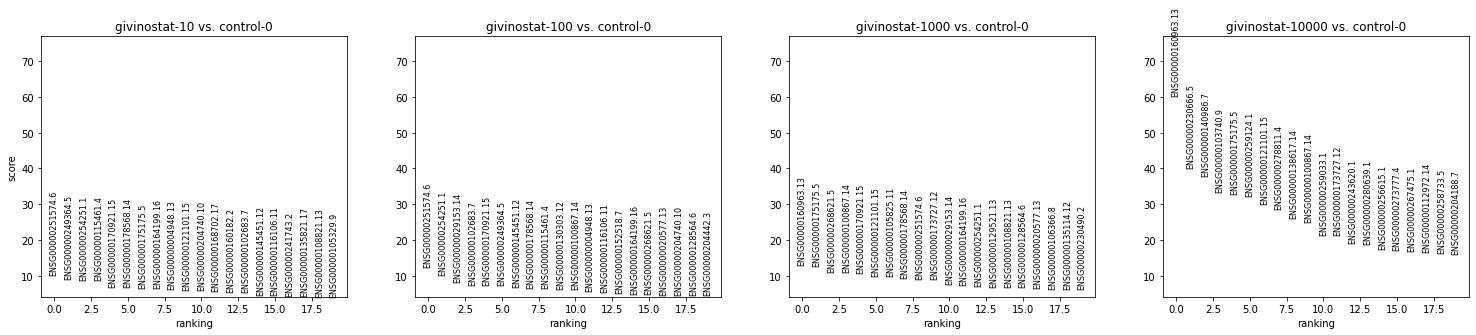

In [32]:
sc.pl.rank_genes_groups(adata_trunk)

In [42]:
# Perturbation Signatures, for all contexts and average.
for each_key in gen_samples.keys():
    print(each_key)
    if each_key == 0:
        
        continue
    gen_mean_vec = torch.mean(gen_samples[each_key],dim=0)
    y_mean_vec = torch.mean(test_samples[each_key],dim=0)
    l2_ps = torch.linalg.norm(gen_mean_vec[marker_indices[each_key]]- y_mean_vec[marker_indices[each_key]])
    print(l2_ps)

0
10
tensor(0.1820)
100
tensor(0.1806)
1000
tensor(0.1323)
10000
tensor(0.1444)


In [ ]:
# Lifted from CellOT
def mmd_distance(x, y, gamma):
    xx = rbf_kernel(x, x, gamma)
    xy = rbf_kernel(x, y, gamma)
    yy = rbf_kernel(y, y, gamma)

    return xx.mean() + yy.mean() - 2 * xy.mean()
 
def compute_scalar_mmd(target, transport, gammas=None):
    if gammas is None:
        gammas = [2, 1, 0.5, 0.1, 0.01, 0.005]

    def safe_mmd(*args):
        try:
            mmd = mmd_distance(*args)
        except ValueError:
            mmd = np.nan
        return mmd

    return np.mean(list(map(lambda x: safe_mmd(target, transport, x), gammas)))

In [ ]:

# for each_key in gen_samples.keys():
#     if each_key == 0:
#         continue
#     print(each_key)
#     mmd_dist = compute_scalar_mmd(gen_samples[each_key][:,marker_indices[each_key]].detach().cpu(),test_samples[each_key][:,marker_indices[each_key]].detach().cpu())
#     print(mmd_dist)

In [43]:
def compute_wasserstein_loss(x, y, epsilon=0.1):
    """Computes transport between x and y via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)

    # compute cost
    geom_xy = pointcloud.PointCloud(x, y, epsilon=epsilon)
    prob = linear_problem.LinearProblem(geom_xy,a,b)
    # solve ot problem
    solver = sinkhorn.Sinkhorn()
    #out_xy = sinkhorn.Sinkhorn(geom_xy, a, b, max_iterations=100, min_iterations=10)
    out = solver(prob)
    # return regularized ot cost
    return out.reg_ot_cost


In [44]:
print('Computing Wass DistThe modified abstract .')
for each_key in gen_samples.keys():
    if each_key == 0:
        continue
    wdist = compute_wasserstein_loss(gen_samples[each_key][:,marker_indices[each_key]].detach().cpu().numpy(),test_samples[each_key][:,marker_indices[each_key]].cpu().numpy())
    wdist = compute_wasserstein_loss(gen_samples[each_key].detach().cpu().numpy(),test_samples[each_key].cpu().numpy())
    print(f'{each_key}:{wdist}')

Computing Wass DistThe modified abstract .
10:19.575448989868164
100:18.8514404296875
1000:18.089401245117188
10000:13.378504753112793


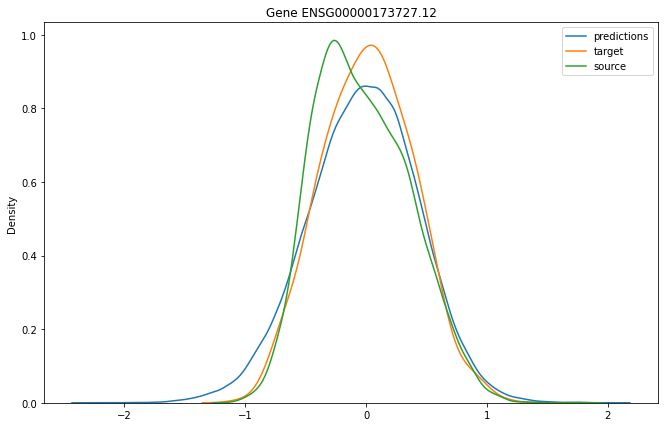

In [35]:
plt.figure(figsize=(11,7))
plt.title('Gene ENSG00000173727.12')
#print(generated[10].shape)
sns.kdeplot(gen_samples[100][:,581].detach().cpu().numpy(), label='predictions')
sns.kdeplot(test_samples[100][:,581].detach().cpu().numpy(), label='target')
sns.kdeplot(gen_samples[0][:,581].cpu().numpy(), label='source')
#sns.kdeplot(cellot_adata.X[:,581], label='cellOT')
plt.legend()
plt.show()